In [1]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st
from scipy.stats import linregress

# 1. Data Retrieval and Cleanup

In this section, we will prepare our raw CDC data for visual and quantitative analysis. We were very fortunate to find such a wealth of data. Thank you, CDC! Only about 6% of the raw dataset could be considered "clean" (no missing datapoints), but the original dataset was so large that we retained nearly half a million rows of patient data.

In [2]:
df = pd.read_csv('http://data.cdc.gov/api/views/vbim-akqf/rows.csv?accessType=DOWNLOAD')
# If you already have the csv file downloaded, replace the above code with: 
    # df = pd.read_csv(<PATH_TO_CSV>)


/home/harry/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#Rename columns for ease of visibility
renames = {'Black, Non-Hispanic': 'Black', 'White, Non-Hispanic': 'White', 'Hispanic/Latino': 'Hispanic',
           'Asian, Non-Hispanic': 'Asian', 'Multiple/Other, Non-Hispanic':'Other', 
           'American Indian/Alaska Native, Non-Hispanic': 'Native', 
           'Native Hawaiian/Other Pacific Islander, Non-Hispanic': 'Pacific Islander'}
for key in renames.keys():
    df = df.replace(key, renames[key])
df.head()

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2020/03/23,2020/03/31,2020/03/23,NaN,Laboratory-confirmed case,Female,0 - 9 Years,Black,Unknown,Unknown,Unknown,Unknown
1,2020/03/22,2020/03/23,2020/03/23,NaN,Laboratory-confirmed case,Female,0 - 9 Years,Hispanic,Yes,Unknown,Unknown,Unknown
2,2020/03/22,2020/03/22,2020/03/23,2020/03/22,Laboratory-confirmed case,Female,0 - 9 Years,Hispanic,No,No,No,No
3,2020/03/23,2020/03/23,2020/03/23,2020/03/23,Laboratory-confirmed case,Female,0 - 9 Years,Hispanic,No,Missing,No,No
4,2020/03/23,2020/03/23,2020/03/23,NaN,Laboratory-confirmed case,Female,0 - 9 Years,Hispanic,Unknown,Unknown,Unknown,Unknown


In [4]:
# Extract month from date
#df.to_csv('new.csv')
def getMonth(date):
    try:
        return date[5:7]
    except:
        return date
df['month'] = df['cdc_report_dt'].apply(getMonth)


In [5]:
# Get rid of missing and unknown data
df = df.replace(['Missing', 'Unknown'], np.nan) #no interest in these rows
df = df.replace('No', 0)
df = df.replace('Yes', 1)

df = df.replace('Male', 1)
df = df.replace('Female', 0)

df['sex'] = df['sex'].replace('Other', np.nan) #Negligle - only like 30 people are "other" in this dataset

#We don't mind keeping nan values for date data, 
#so we need to replace nan with something that won't be dropped by dropna
df['pos_spec_dt'] = df['pos_spec_dt'].replace(np.nan, '--')
df['onset_dt'] = df['onset_dt'].replace(np.nan, '--')
dropped = df.dropna()
df.head()

# We still have almost half a million rows that have every single one of our desired datapoints

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn,month
0,2020/03/23,2020/03/31,2020/03/23,--,Laboratory-confirmed case,0.0,0 - 9 Years,Black,NaN,NaN,NaN,NaN,03
1,2020/03/22,2020/03/23,2020/03/23,--,Laboratory-confirmed case,0.0,0 - 9 Years,Hispanic,1.0,NaN,NaN,NaN,03
2,2020/03/22,2020/03/22,2020/03/23,2020/03/22,Laboratory-confirmed case,0.0,0 - 9 Years,Hispanic,0.0,0.0,0.0,0.0,03
3,2020/03/23,2020/03/23,2020/03/23,2020/03/23,Laboratory-confirmed case,0.0,0 - 9 Years,Hispanic,0.0,NaN,0.0,0.0,03
4,2020/03/23,2020/03/23,2020/03/23,--,Laboratory-confirmed case,0.0,0 - 9 Years,Hispanic,NaN,NaN,NaN,NaN,03


In [6]:
# Save clean dataframe
dropped.to_csv('Data/clean_data.csv', index=False)

## Bias
### Have we introduced bias into our sample?
We have cut down our sample size by more than 90%. Thankfully, even when we're extremely picky, and we don't allow for *any* datapoints to be missing (convenient for quantitative analysis), we still have almost half a *million* cases of Covid-19 to examine.

Thanks to the CDC's huge amount of data collected, we can prune down the data, and we still have 10x the sample size that Pfizer had for its phase 3 Covid vaccine trials (which just got approved

So, we don't have to worry about whether or not we have removed *too much* of the dataset, but we do have to worry about the possibility of bias. Did we remove rows randomly, or did we introduce bias? 

---
### Random selection
To understand why the question of randomness is so important, think of a simple example: You have a dataset of one billion men, sampled from the globe at random. The two columns of information are height and nationality. You find that the average height for men is 176.5 cm. Now, think of three distinct scenarios:

Scenario 1: You RANDOMLY select 1000 (0.1%) of the men. Do you think the average height will still be 176.5 cm?

Scenario 2: You select 1000 men, but you make sure they are ALL from the country of Norway (an especially tall country). Now, do you think the new average will reflect the global average?

Scenario 3: You select 1000 men, but you make sure that you ONLY select men who wore red hats today. Now, do you think the new average will reflect the global average?

Both scenario 2 and 3 are highly UN-random, but only one is a biased sample of height. The sample average height for scenario 3 should yield the same value as the global population average. This is because nationality correlates with height, and the wearing of red hats does not.

---
### CDC Data Sampling
This is the question we need to be asking ourselves: Is our selection criteria (the full availability of hospital data) correlated with our dependent variable (death)?
When we drop these 7.5 million incomplete rows, is it more akin to the nationality example, or the red hats example?

We can explore this question intuitively and quantitatively. Intuitively, I would make the argument that there is unlikely to be any correlation between a hospital's data-reporting and its patient outcomes. I imagine that the staff who generate these datasets are not doctors, and the quality of their work does not reflect the quality of the medical work at these hospitals. I would assume based on intuition that the quality of medical care and the quality of reported data are completely independent of one another. 

One great way to look for bias is to visualize the distribution of population fields. In this case, intuition prevails. The distributions are nearly identical after performing the data pruning.

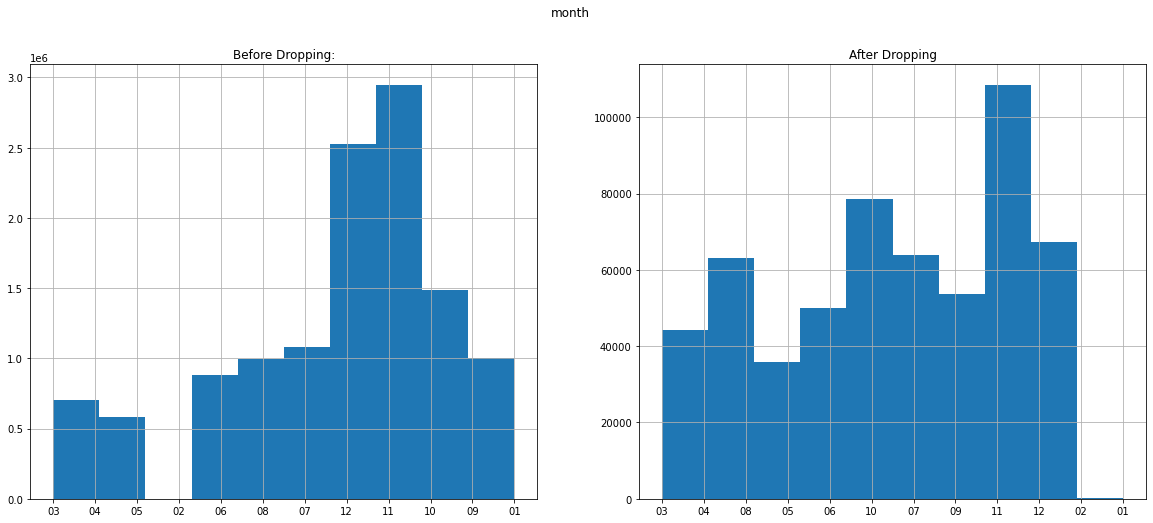

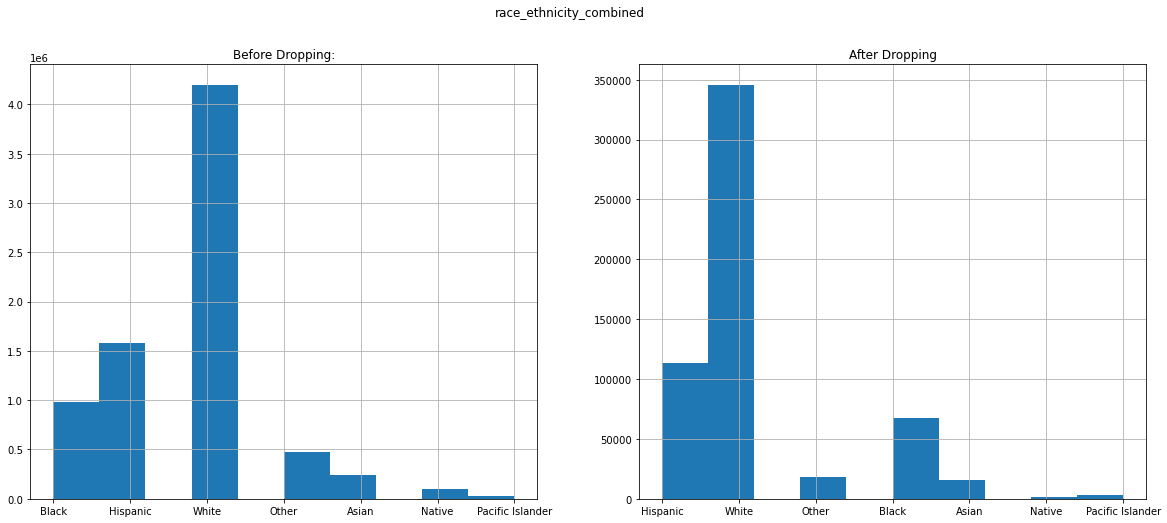

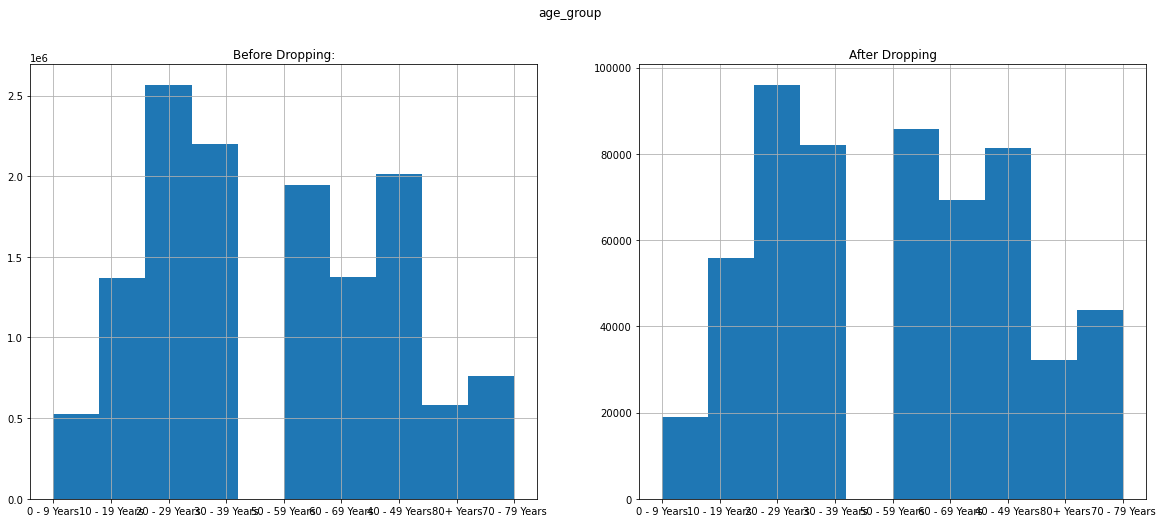

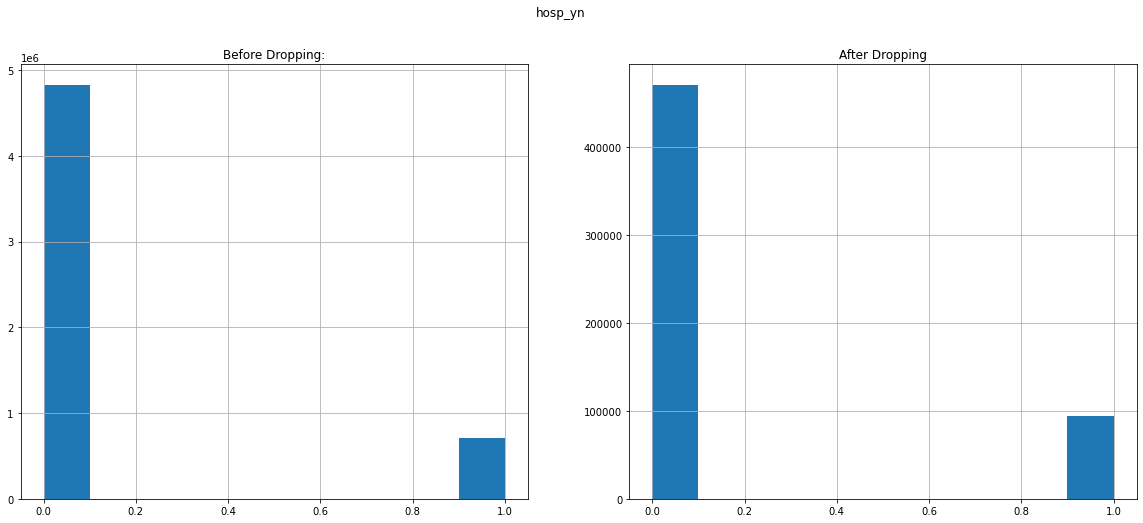

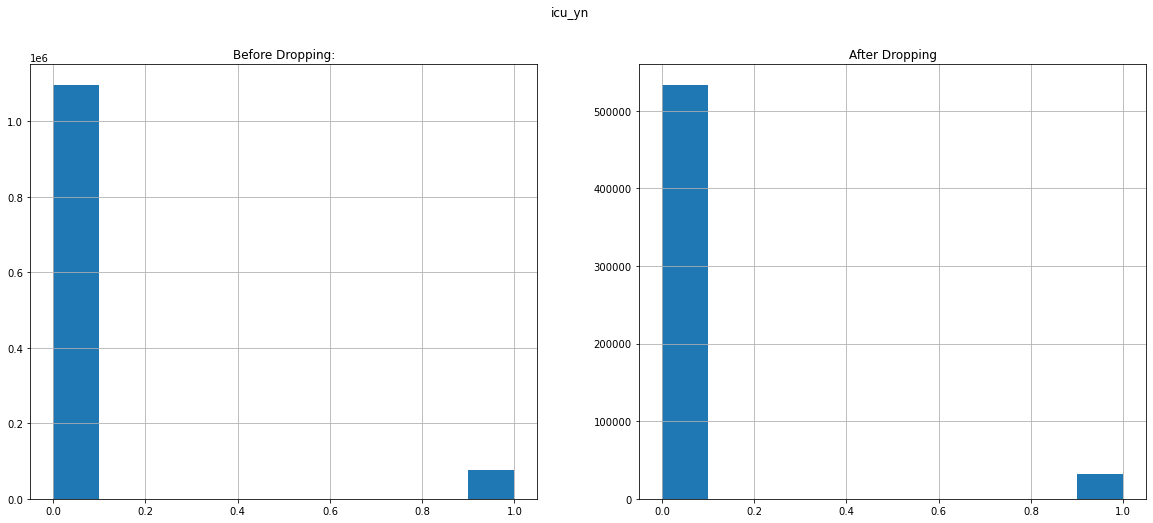

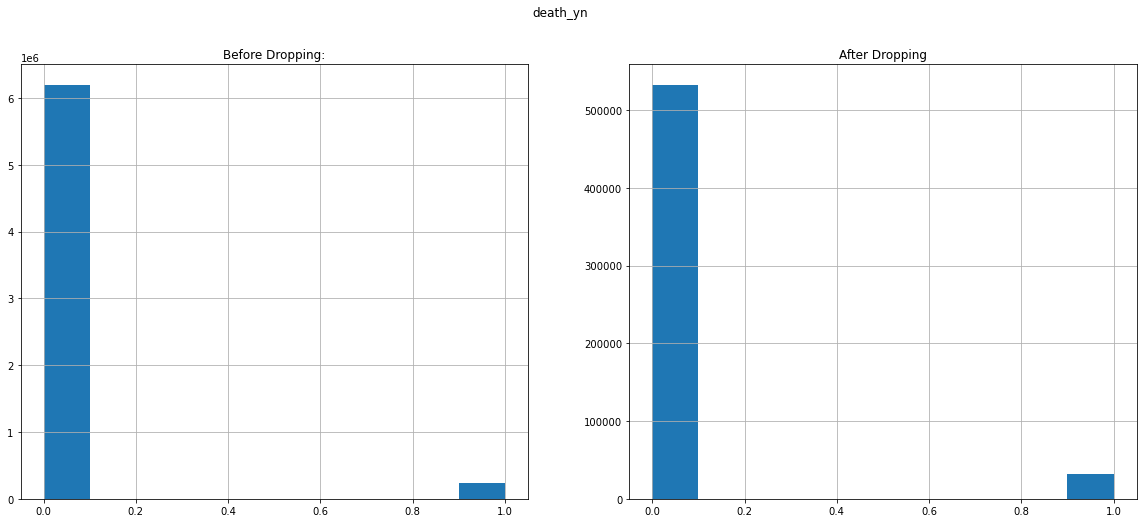

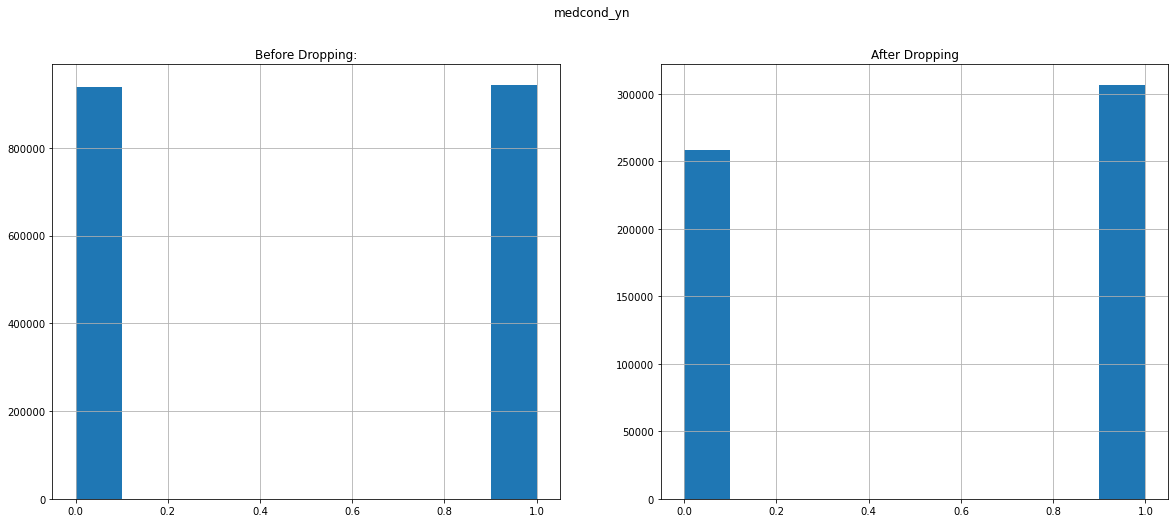

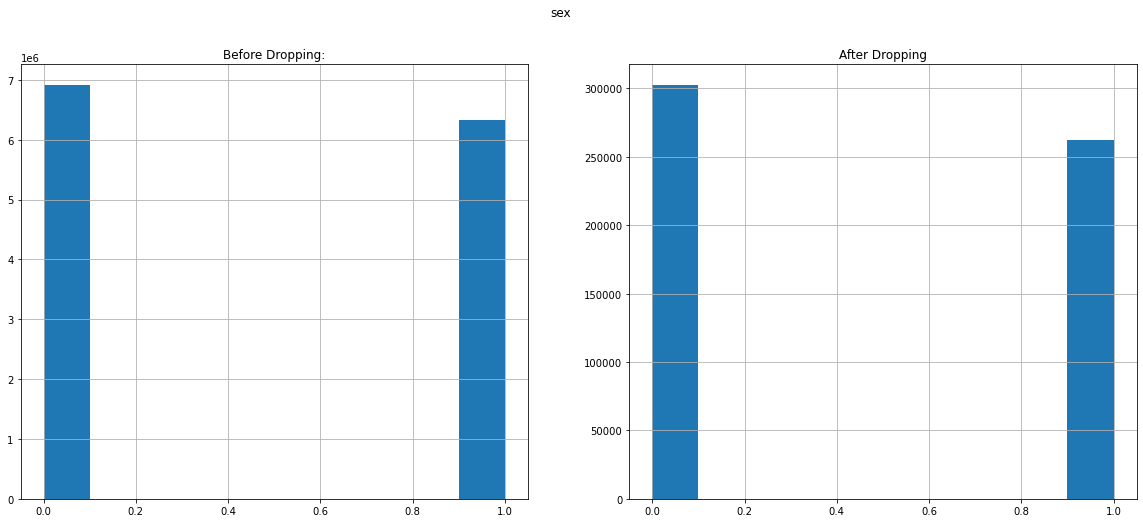

In [7]:
#Generate a histogram of the two dataframes - one with dropped values, the other without
def compareHistogram(col):
    fig, axs = plt.subplots(1,2, figsize= (20,8))
    fig.suptitle(col)
    
    df[col].hist(ax = axs[0])
    axs[0].set_title('Before Dropping:')

    dropped[col].hist(ax = axs[1])
    axs[1].set_title('After Dropping')
    plt.savefig('Images/drop_data_comparisons/' + col + '.png', facecolor = 'white')

    
for column in ['month','race_ethnicity_combined', 'age_group', 'hosp_yn','icu_yn','death_yn','medcond_yn', 'sex']:
    compareHistogram(column)

# 1.1 Gather Hospital Data from Health.gov 
We will group this data by month so as to get a general picture of the country 

State-by-state information (like the information in this particular dataset) is not of any interest to our analysis, because there is no location data in the CDC dataset

In [8]:
df = pd.read_csv('https://healthdata.gov/sites/default/files/reported_hospital_utilization_timeseries_20201213_2141.csv')
df

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,inpatient_bed_covid_utilization_numerator,inpatient_bed_covid_utilization_denominator,adult_icu_bed_covid_utilization,adult_icu_bed_covid_utilization_coverage,adult_icu_bed_covid_utilization_numerator,adult_icu_bed_covid_utilization_denominator,adult_icu_bed_utilization,adult_icu_bed_utilization_coverage,adult_icu_bed_utilization_numerator,adult_icu_bed_utilization_denominator
0,NJ,2020-08-26,9,63,5,9,63,5,52.0,70,...,615.0,19692.0,0.055507,71.0,64.0,1153.0,1.127426,72.0,1336.0,1185.0
1,NM,2020-08-26,12,34,2,12,34,2,1.0,47,...,111.0,3190.0,0.084746,42.0,30.0,354.0,0.672973,42.0,249.0,370.0
2,NV,2020-08-26,8,49,4,10,47,4,33.0,59,...,832.0,8339.0,0.253450,58.0,202.0,797.0,0.758980,61.0,655.0,863.0
3,NY,2020-08-26,8,112,46,7,112,47,18.0,131,...,1566.0,42349.0,0.045967,106.0,212.0,4612.0,0.573216,116.0,2795.0,4876.0
4,OH,2020-08-26,10,82,115,11,79,117,10.0,91,...,1400.0,30450.0,0.087094,184.0,357.0,4099.0,0.643901,192.0,2687.0,4173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15482,MN,2020-01-01,0,0,1,0,0,1,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15483,MT,2020-01-01,0,0,1,0,0,1,0.0,1,...,0.0,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15484,NC,2020-01-01,0,0,1,0,0,1,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15485,PR,2020-01-01,0,0,1,0,0,1,0.0,1,...,0.0,146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
occupancy = df[['date', 'adult_icu_bed_covid_utilization', 'inpatient_beds_utilization', 'percent_of_inpatients_with_covid']]

def getMonth(date):
    return date[5:7]

# Group by month
occupancy['month'] = occupancy['date'].apply(getMonth)
occupancy = occupancy.groupby('month', dropna = False).mean()[['adult_icu_bed_covid_utilization', 'inpatient_beds_utilization', 'percent_of_inpatients_with_covid']]
occupancy

<ipython-input-9-36e569719a3b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occupancy['month'] = occupancy['date'].apply(getMonth)


,adult_icu_bed_covid_utilization,inpatient_beds_utilization,percent_of_inpatients_with_covid
month,,,
01,0.000000,0.424642,0.000000
02,NaN,0.461779,0.004861
03,NaN,0.518818,0.067229
04,0.076896,0.510773,0.148326
05,NaN,0.600794,0.111960
06,NaN,0.637689,0.078412
07,0.165340,0.664927,0.105063
08,0.151257,0.663529,0.087548
09,0.116432,0.661602,0.068433


In [10]:
# Save Data
df.to_csv('Data/hospital_info.csv', index=False)
occupancy.to_csv('Data/hospital_occupancy.csv')

# 1.2 Merge Hospital Data into Main CDC Dataset

In [11]:
df = pd.read_csv('Data/clean_data.csv')
cap = pd.read_csv('Data/hospital_occupancy.csv', index_col = False)
cap

,month,adult_icu_bed_covid_utilization,inpatient_beds_utilization,percent_of_inpatients_with_covid
0,1,0.000000,0.424642,0.000000
1,2,NaN,0.461779,0.004861
2,3,NaN,0.518818,0.067229
3,4,0.076896,0.510773,0.148326
4,5,NaN,0.600794,0.111960
5,6,NaN,0.637689,0.078412
6,7,0.165340,0.664927,0.105063
7,8,0.151257,0.663529,0.087548
8,9,0.116432,0.661602,0.068433
9,10,0.139070,0.680998,0.084843


In [12]:
# Perform Merge
df = pd.merge(df, cap[['month', 'inpatient_beds_utilization', 'percent_of_inpatients_with_covid']], on = 'month').rename(columns={
    
    'inpatient_beds_utilization': 'inpatient__occupancy'
    
})
df.head()

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn,month,inpatient__occupancy,percent_of_inpatients_with_covid
0,2020/03/22,2020/03/22,2020/03/23,2020/03/22,Laboratory-confirmed case,0.0,0 - 9 Years,Hispanic,0.0,0.0,0.0,0.0,3,0.518818,0.067229
1,2020/03/22,2020/03/26,2020/03/23,2020/03/22,Laboratory-confirmed case,1.0,0 - 9 Years,White,1.0,0.0,0.0,1.0,3,0.518818,0.067229
2,2020/03/22,2020/03/22,2020/03/23,2020/03/22,Laboratory-confirmed case,1.0,0 - 9 Years,White,0.0,0.0,0.0,0.0,3,0.518818,0.067229
3,2020/03/23,2020/03/27,2020/03/24,2020/03/23,Laboratory-confirmed case,0.0,0 - 9 Years,Other,0.0,0.0,0.0,0.0,3,0.518818,0.067229
4,2020/03/21,2020/03/21,2020/03/24,2020/03/21,Laboratory-confirmed case,0.0,0 - 9 Years,White,0.0,0.0,0.0,1.0,3,0.518818,0.067229


In [13]:
# Save (and overwrite) data.
df.to_csv('Data/clean_data.csv', index= False)

# 2. Data Exploration and Visualization

## Gender

## Are more men dying from COVID-19 than women?

In [14]:
df = pd.read_csv('./Data/clean_data.csv')

# Are more men dying from COVID-19 than women?

clean_data_df = df

# Calculate the distribution of female versus male COVID-19 Cases
total_cases= len(clean_data_df['sex'])

by_gender_count=clean_data_df["sex"].value_counts()

by_gender_pct = (100*(by_gender_count/total_cases)).round(2)

# Calculate the distribution of female versus male deaths by COVID-19
death = clean_data_df[(clean_data_df['death_yn'] == 1.0)]
total_death = len(death['death_yn'])
by_gender_death=death["sex"].value_counts()
by_gender_death_pct = (100*(by_gender_death/total_death)).round(2)


# Calculate the distribution of female versus male deaths with underlying medical condition by COVID-19
death_med_cond = death[(death['medcond_yn'] == 1.0)]
total_death_med_cond = len(death_med_cond['medcond_yn'])
by_gender_death_med_cond = death_med_cond["sex"].value_counts()
by_gender_death_med_cond_pct = (100*(by_gender_death_med_cond/total_death_med_cond)).round(2)

# Assemble the resulting series into a single summary dataframe.
gender_df = pd.DataFrame({"Sex": ["Female", "Male"],
                          "Number of Cases": by_gender_count,
                          "Share of Cases (%)": by_gender_pct,
                          "Number of Deaths":by_gender_death,
                          "Share of Deaths (%)":by_gender_death_pct,
                          "Deaths with underlying condition": by_gender_death_med_cond,
                          "Share of Death with underlying condition (%)":by_gender_death_med_cond_pct })

gender_df

,Sex,Number of Cases,Share of Cases (%),Number of Deaths,Share of Deaths (%),Deaths with underlying condition,Share of Death with underlying condition (%)
0.0,Female,302803,53.58,13792,42.62,12885,42.56
1.0,Male,262321,46.42,18568,57.38,17391,57.44


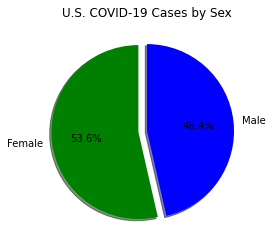

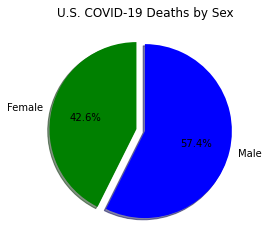

In [15]:
### COVID-19 Cases and Deaths Disaggregated by Sex

# Pie plot showing the distribution of male versus female COVID-19 Cases

# Create Labels for the sections of the pie
labels = gender_df["Sex"]
distribution = gender_df["Share of Cases (%)"]

# Pie plot using pyplot
plt.pie(distribution, labels=labels, colors = ['green', 'blue'],explode = (0.1, 0), autopct="%1.1f%%",shadow=True, startangle=90 )

#Formatting
plt.title("U.S. COVID-19 Cases by Sex")

plt.savefig('Images/US_Covid_cases_by_sex.png')
plt.show()

# Pie plot showing the distribution of male versus female deaths by COVID-19 Cases

# Create Labels for the sections of the pie
labels = gender_df["Sex"]
distribution = gender_df["Share of Deaths (%)"]

# Pie plot using pyplot
plt.pie(distribution, labels=labels, colors = ['green', 'blue'],explode = (0.1, 0), autopct="%1.1f%%",shadow=True, startangle=90 )

#Formatting
plt.title("U.S. COVID-19 Deaths by Sex")

plt.savefig('Images/US_Covid_deaths_by_sex.png')
plt.show()

After analyzing and comparing the pie chart U.S. COVID-19 cases and deaths, it is possible to observe that the female gender has a larger percentage of getting the COVID disease and the male gender has a larger percentage of deaths. The ratio of COVID-19 by sex mortality rate shows that men has 1.4 chances of dying compared to women indicating that for every 10 deaths among confirmed cases in women, there are 14 death in men.

In [16]:
### Rate Ratio of COVID-19 by Sex Mortality Rate

total_pct_deaths =(100*(by_gender_death/total_cases)).round(2)


sex_ratio_df = pd.DataFrame({"Sex": ["Female", "Male"],
                          "Number of Cases": by_gender_count,
                          "Number of Deaths":by_gender_death,
                          "Total Deaths (%)":total_pct_deaths})
sex_ratio_df

,Sex,Number of Cases,Number of Deaths,Total Deaths (%)
0.0,Female,302803,13792,2.44
1.0,Male,262321,18568,3.29


Men have 1.3 chances of dying than women.
For every 10 deaths among confirmed cases in women, there are 13 death in men.


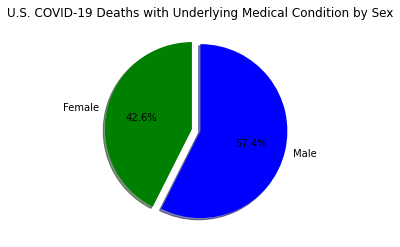

In [17]:
male_female_radio = (total_pct_deaths[1]/total_pct_deaths[0]).round(1)
print(f'Men have {male_female_radio} chances of dying than women.')
print(f'For every 10 deaths among confirmed cases in women, there are {"{:.0f}".format(10*male_female_radio)} death in men.')

### Possible Risk Factors  

# Pie plot showing the distribution of male versus female deaths by COVID-19 Cases with underlying medical conditions

# Create Labels for the sections of the pie
labels = gender_df["Sex"]
distribution = gender_df["Share of Death with underlying condition (%)"]

# Pie plot using pyplot
plt.pie(distribution, labels=labels, colors = ['green', 'blue'],explode = (0.1, 0), autopct="%1.1f%%",shadow=True, startangle=90 )

#Formatting
plt.title("U.S. COVID-19 Deaths with Underlying Medical Condition by Sex")

plt.savefig('Images/US_Covid_deaths_with_medcond_by_sex.png')
plt.show()

A pie plot of deaths related to people with underlying medical conditions was generated to understand the possible risk factor of why more men are dying due to COVID-19. The result shows that the percentage of female and male remains the same as the pie plot “U.S. Covid-19 deaths by sex” shown previously indicating that underlying condition does not change the odds of men dying from COVID-19 over women.

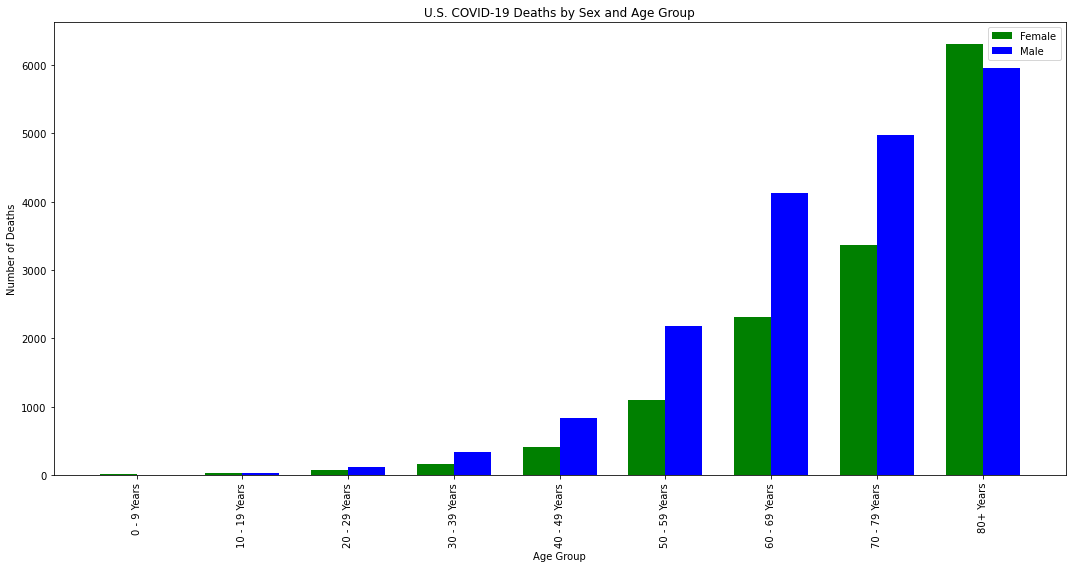

In [18]:
# Calculating the distribution of male versus female deaths by COVID-19 Cases base on age groups

# Number of death in womens by age groups
woman_death = clean_data_df[((clean_data_df['sex'] == 0) & (clean_data_df['death_yn'] == 1.0))]
woman_age_group_deaths = woman_death.groupby(["age_group"]).count()["death_yn"]

# Number of death in male by age group 
men_death = clean_data_df[((clean_data_df['sex'] == 1.0) & (clean_data_df['death_yn'] == 1.0))]
men_age_group_deaths = men_death.groupby(["age_group"]).count()["death_yn"]
men_age_group_deaths

# Bar plot showing the distribution of male versus female deaths by COVID-19 Cases base on age groups

labels = ['0 - 9 Years', '10 - 19 Years', '20 - 29 Years', '30 - 39 Years',
        '40 - 49 Years', '50 - 59 Years', '60 - 69 Years', '70 - 79 Years', '80+ Years']
y = woman_age_group_deaths
y1 = men_age_group_deaths

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (15,8))
rects1 = ax.bar(x - width/2, y, width, label='Female', color='g')
rects2 = ax.bar(x + width/2, y1, width, label='Male', color='b')
ax.set_xlabel('Age Group')
ax.set_ylabel('Number of Deaths')
ax.set_title('U.S. COVID-19 Deaths by Sex and Age Group')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
ax.legend()
fig.tight_layout()

plt.savefig('Images/US_Covid_deaths_by_sex_and_age.png')
plt.show()

Another factor taken into consideration in this analysis was the age group associated with U.S Covid-19 deaths. The bar plot shows the distribution of number of deaths in males and females vs the age groups. The result shows a consistent higher percentage of male dying compared to women (excluding age 80+ age group) and it is more pronounced between males of age groups 60 to 79 years. In the 80+ years group, the relationship changes (more females dying over male) but research studies from other countries show a consistent higher percentage of male dying compared to women in all age groups. This bias in the data is related to women living six years longer than men on average, meaning that there are more elderly women in the vulnerable population than men.

### Are people with underlying health conditions at a higher risk of having serious symptoms of COVID-19?

In [19]:
## Are people with underlying health conditions at higher risk of serious symptoms of COVID-19?

clean_data_df = df

# Calculate the distribution of COVID-19 Cases with underlying health conditions.
total_cases= len(clean_data_df['medcond_yn'])
med_cond_count=clean_data_df["medcond_yn"].value_counts()
med_cond_pct = (100*(med_cond_count/total_cases)).round(2)

# Calculate the distribution with underlying health conditions deaths by COVID-19
death = clean_data_df[(clean_data_df['death_yn'] == 1.0)]
total_death = len(death['death_yn'])
med_cond_death=death["medcond_yn"].value_counts()
med_cond_death_share = (100*(med_cond_death/total_death)).round(2)
med_cond_death_pct = (100*(med_cond_death/total_cases)).round(2)

# Calculate the distribution hospitalization with underlying medical conditions by COVID-19
hospitalization = clean_data_df[(clean_data_df['hosp_yn'] == 1.0)]
total_hospitalization = len(hospitalization['hosp_yn'])
med_cond_hospitalization=hospitalization["medcond_yn"].value_counts()
med_cond_hospitalization_share = (100*(med_cond_hospitalization/total_hospitalization)).round(2)
med_cond_hospitalization_pct = (100*(med_cond_hospitalization/total_cases)).round(2)

# Calculate the distribution ICU admission with underlying medical conditions by COVID-19
icu = clean_data_df[(clean_data_df['icu_yn'] == 1.0)]
total_icu = len(icu['icu_yn'])
med_cond_icu=icu["medcond_yn"].value_counts()
med_cond_icu_share = (100*(med_cond_icu/total_icu)).round(2)
med_cond_icu_pct = (100*(med_cond_icu/total_cases)).round(2)

# Assemble the resulting series into a single summary dataframe.
med_cond_df = pd.DataFrame({"Medical Condition": ["Yes", "No"],
                          "Number of Cases": med_cond_count,
                          "Cases (%)": med_cond_pct,
                          "Number of Hospitalizations": med_cond_hospitalization,
                          "Share of Hospitalizations (%)": med_cond_hospitalization_share,
                          "Hospitalizations (%)": med_cond_hospitalization_pct, 
                          "Number of ICU Admissions": med_cond_icu,
                          "Share of ICU Admissions (%)": med_cond_icu_share,
                          "ICU Admissions (%)": med_cond_icu_pct,
                          "Number of Deaths": med_cond_death,
                          "Share of Death (%)": med_cond_death_share,
                          "Death (%)": med_cond_death_pct})
med_cond_df

,Medical Condition,Number of Cases,Cases (%),Number of Hospitalizations,Share of Hospitalizations (%),Hospitalizations (%),Number of ICU Admissions,Share of ICU Admissions (%),ICU Admissions (%),Number of Deaths,Share of Death (%),Death (%)
1.0,Yes,306797,54.29,78709,83.8,13.93,27783,88.42,4.92,30276,93.56,5.36
0.0,No,258327,45.71,15219,16.2,2.69,3637,11.58,0.64,2084,6.44,0.37


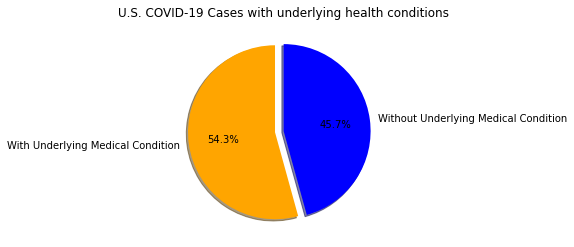

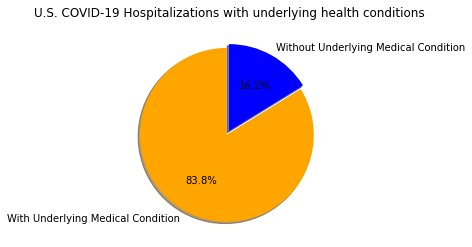

In [20]:
### Plots of distribution of COVID-19 Cases by shares with and without underlying health conditions.

# Pie plot showing the distribution of COVID-19 Cases with and without underlying health conditions

# Create Labels for the sections of the pie
labels = ["With Underlying Medical Condition","Without Underlying Medical Condition" ]
distribution = med_cond_df["Cases (%)"]

# Pie plot using pyplot
plt.pie(distribution, labels=labels, colors = ['orange', 'blue'],explode = (0.1, 0), autopct="%1.1f%%",shadow=True, startangle=90 )

#Formatting
plt.title("U.S. COVID-19 Cases with underlying health conditions")

plt.savefig('Images/US_Covid_cases_with_medcond.png')
plt.show()

# Pie plot showing the distribution of COVID-19 Hospitalizations with and without underlying health conditions

# Create Labels for the sections of the pie
labels = ["With Underlying Medical Condition","Without Underlying Medical Condition" ]
distribution = med_cond_df["Share of Hospitalizations (%)"]

# Pie plot using pyplot
plt.pie(distribution, labels=labels, colors = ['orange', 'blue'],explode = (0.05, 0), autopct="%1.1f%%",shadow=True, startangle=90 )

#Formatting
plt.title("U.S. COVID-19 Hospitalizations with underlying health conditions")

plt.savefig('Images/US_Covid_hospitalizations_with_medcond.png')
plt.show()

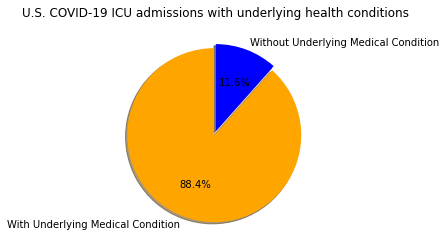

In [21]:
# Pie plot showing the distribution of COVID-19 ICU admissions with and without underlying health conditions

# Create Labels for the sections of the pie
labels = ["With Underlying Medical Condition","Without Underlying Medical Condition" ]
distribution = med_cond_df["Share of ICU Admissions (%)"]

# Pie plot using pyplot
plt.pie(distribution, labels=labels, colors = ['orange', 'blue'],explode = (0.05, 0), autopct="%1.1f%%",shadow=True, startangle=90 )

#Formatting
plt.title("U.S. COVID-19 ICU admissions with underlying health conditions")

plt.savefig('Images/US_Covid_ICU_with_medcond.png')
plt.show()

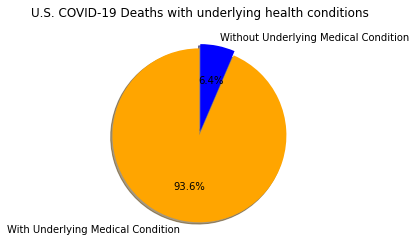

In [22]:
# Pie plot showing the distribution of COVID-19 Deaths with and without underlying health conditions

# Create Labels for the sections of the pie
labels = ["With Underlying Medical Condition","Without Underlying Medical Condition" ]
distribution = med_cond_df["Share of Death (%)"]

# Pie plot using pyplot
plt.pie(distribution, labels=labels, colors = ['orange', 'blue'],explode = (0.05, 0), autopct="%1.1f%%",shadow=True, startangle=90 )

#Formatting
plt.title("U.S. COVID-19 Deaths with underlying health conditions")

plt.savefig('Images/US_Covid_deaths_with_medcond.png')
plt.show()

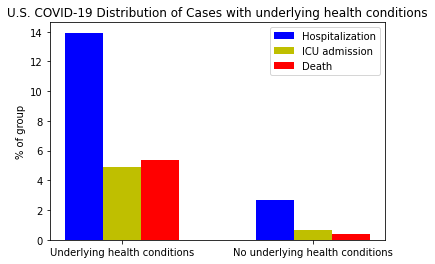

In [23]:
### Bar plot of distribution of COVID-19 Risk with underlying health conditions.

# Bar plot showing the distribution of COVID-19 Cases with underlying health conditions.

labels = ['Underlying health conditions', 'No underlying health conditions']
y1 = med_cond_hospitalization_pct
y2 = med_cond_icu_pct
y3 = med_cond_death_pct

x = np.arange(len(labels))  # the label locations
width = 0.2


fig, ax = plt.subplots()
rects2 = ax.bar(x - width, y1, width, label='Hospitalization', color='b')
rects3 = ax.bar(x , y2, width, label='ICU admission', color='y')
rects4 = ax.bar(x + width, y3, width, label='Death', color='r')
ax.set_ylabel('% of group')
ax.set_title('U.S. COVID-19 Distribution of Cases with underlying health conditions')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='horizontal')
ax.legend()

plt.savefig('Images/US_Covid_distribution_of_cases_with_medcond.png')
plt.show()

A bar plot was generated to show the distribution of percentages of hospitalizations, ICU admissions and death for people with and without underlying medical conditions. The objective of this plot is to further interrogate the data and try to understand if people with underlying health conditions are at higher risk of serious symptoms of COVID-19. The results clearly show a higher risk of getting hospitalized, admitted to the ICU unit or fatalities in people with underlying medical conditions.

In [24]:
###  Risk Rate Ratio of COVID-19 Cases with underlying health conditions.

# Hospitalization risk ratio
hospitalization_radio = (med_cond_hospitalization_pct[1]/med_cond_hospitalization_pct[0]).round(1)
print(f'COVID-19 patients with an underlying medical condition are {hospitalization_radio} times as likely to be hospitalized.')

# ICU admission risk ratio
ICU_radio = (med_cond_icu_pct[1]/med_cond_icu_pct[0]).round(1)
print(f'COVID-19 patients with an underlying medical condition are {ICU_radio} times as likely to be ICU admitted.')

# Death risk ratio
death_radio = (med_cond_death_pct[1]/med_cond_death_pct[0]).round(1)
print(f'COVID-19 patients with an underlying medical condition are {ICU_radio} times as likely to die.')

COVID-19 patients with an underlying medical condition are 5.2 times as likely to be hospitalized.
COVID-19 patients with an underlying medical condition are 7.7 times as likely to be ICU admitted.
COVID-19 patients with an underlying medical condition are 7.7 times as likely to die.


In [25]:
### Conditions contributing to deaths involving coronavirus disease 2019 (COVID-19) in U.S.

# Import the data from Centers for Disease Control and Prevention
med_condition_df = pd.read_csv('http://data.cdc.gov/api/views/hk9y-quqm/rows.csv?accessType=DOWNLOAD')

# Data conditioning
med_condition_df = med_condition_df.replace('COVID-19', 0)
indexNames = med_condition_df[med_condition_df['Condition Group'] == 0 ].index
med_condition_df.drop(indexNames , inplace=True)

# Conditions contributing to deaths involving coronavirus disease 2019 (COVID-19) in U.S. 
med_condition_df

,Data as of,Start Week,End Week,State,Condition Group,Condition,ICD10_codes,Age Group,COVID-19 Deaths,Number of Mentions,Flag
0,12/27/2020,02/01/2020,12/26/2020,US,Respiratory diseases,Influenza and pneumonia,J09-J18,0-24,186.0,193.0,NaN
1,12/27/2020,02/01/2020,12/26/2020,US,Respiratory diseases,Influenza and pneumonia,J09-J18,25-34,924.0,941.0,NaN
2,12/27/2020,02/01/2020,12/26/2020,US,Respiratory diseases,Influenza and pneumonia,J09-J18,35-44,2387.0,2431.0,NaN
3,12/27/2020,02/01/2020,12/26/2020,US,Respiratory diseases,Influenza and pneumonia,J09-J18,45-54,6791.0,6964.0,NaN
4,12/27/2020,02/01/2020,12/26/2020,US,Respiratory diseases,Influenza and pneumonia,J09-J18,55-64,16901.0,17298.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
12405,12/27/2020,02/01/2020,12/26/2020,PR,All other conditions and causes (residual),All other conditions and causes (residual),"A00-A39, A42-B99, D00-E07, E15-E64, E70-E90, F...",65-74,113.0,174.0,NaN
12406,12/27/2020,02/01/2020,12/26/2020,PR,All other conditions and causes (residual),All other conditions and causes (residual),"A00-A39, A42-B99, D00-E07, E15-E64, E70-E90, F...",75-84,122.0,173.0,NaN
12407,12/27/2020,02/01/2020,12/26/2020,PR,All other conditions and causes (residual),All other conditions and causes (residual),"A00-A39, A42-B99, D00-E07, E15-E64, E70-E90, F...",85+,89.0,126.0,NaN
12408,12/27/2020,02/01/2020,12/26/2020,PR,All other conditions and causes (residual),All other conditions and causes (residual),"A00-A39, A42-B99, D00-E07, E15-E64, E70-E90, F...",Not stated,0.0,0.0,NaN


In [26]:
# Save clean dataframe
med_condition_df.to_csv('./Data/preexisten_med_conditions_data.csv', index=False)

# Medical Condition data frame
drop_columns = med_condition_df.drop(columns=['Data as of','Start Week', 'End Week','State', 'ICD10_codes', 'Age Group', 'Number of Mentions', 'Flag'])
drop_columns

condition_df = pd.DataFrame(drop_columns.groupby(["Condition Group"]).count())
condition_df.columns = ["Total Count", "Total Deaths"]
condition_df = condition_df.sort_values(by='Total Count', ascending=False)

# Calculate percentage
condition_df["Condition Percentage (%)"] = (100*(condition_df["Total Count"]/condition_df["Total Count"].sum())).round(2)

condition_df

,Total Count,Total Deaths,Condition Percentage (%)
Condition Group,,,
Circulatory diseases,3780,2867,31.82
Respiratory diseases,3240,2478,27.27
All other conditions and causes (residual),540,455,4.55
Alzheimer disease,540,461,4.55
Diabetes,540,432,4.55
"Intentional and unintentional injury, poisoning, and other adverse events",540,347,4.55
Malignant neoplasms,540,391,4.55
Obesity,540,368,4.55
Renal failure,540,413,4.55


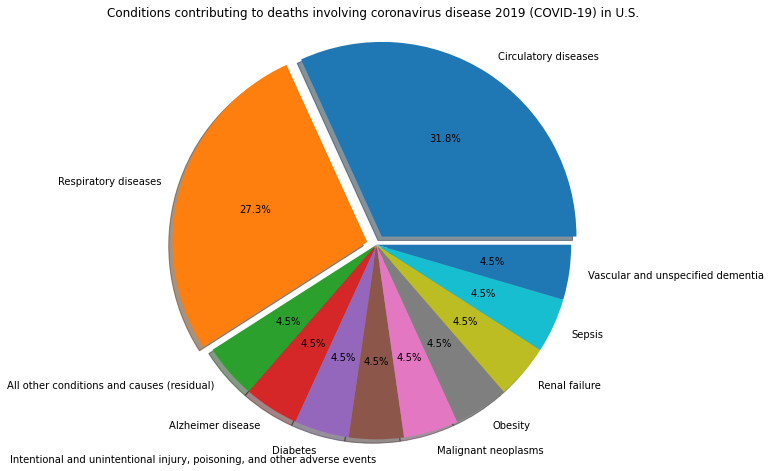

In [27]:
# Pie plot showing conditions contributing to deaths involving coronavirus disease 2019 (COVID-19) in U.S. 

# Create Labels for the sections of the pie
labels = condition_df.index
condition = condition_df['Condition Percentage (%)']
explode = (0.05, 0.05, 0, 0, 0, 0, 0, 0, 0, 0, 0)

# Pie plot using pyplot
fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(condition, explode=explode, labels=labels , autopct='%1.1f%%', shadow=True)
ax1.axis('equal')  

#Formatting
plt.title("Conditions contributing to deaths involving coronavirus disease 2019 (COVID-19) in U.S.")

plt.savefig('Images/US_Covid_med_conditions_contributing_death.png')
plt.show()

The pie plot shows the primary health conditions contributing to deaths associated with COVID-19 disease in the U.S.

## Ethnicity

In [28]:
#importing the csv file
file = pd.read_csv('./Data/clean_data.csv')
file.head()

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn,month,inpatient__occupancy,percent_of_inpatients_with_covid
0,2020/03/22,2020/03/22,2020/03/23,2020/03/22,Laboratory-confirmed case,0.0,0 - 9 Years,Hispanic,0.0,0.0,0.0,0.0,3,0.518818,0.067229
1,2020/03/22,2020/03/26,2020/03/23,2020/03/22,Laboratory-confirmed case,1.0,0 - 9 Years,White,1.0,0.0,0.0,1.0,3,0.518818,0.067229
2,2020/03/22,2020/03/22,2020/03/23,2020/03/22,Laboratory-confirmed case,1.0,0 - 9 Years,White,0.0,0.0,0.0,0.0,3,0.518818,0.067229
3,2020/03/23,2020/03/27,2020/03/24,2020/03/23,Laboratory-confirmed case,0.0,0 - 9 Years,Other,0.0,0.0,0.0,0.0,3,0.518818,0.067229
4,2020/03/21,2020/03/21,2020/03/24,2020/03/21,Laboratory-confirmed case,0.0,0 - 9 Years,White,0.0,0.0,0.0,1.0,3,0.518818,0.067229


In [29]:
#organizing different enthnicities by month

dates = file[['month','race_ethnicity_combined',"death_yn"]]

total_cases_by_month = dates.groupby(['month','race_ethnicity_combined']).count()
total_cases_by_month

death_yn
month race_ethnicity_combined          
1     Asian                           4
      Black                           2
      Hispanic                        2
      White                           6
2     Asian                           6
...                                 ...
12    Hispanic                     8742
      Native                        119
      Other                        2780
      Pacific Islander              168
      White                       46778

[79 rows x 1 columns]

In [30]:
#pulling out just the deaths
deaths = dates.groupby(dates["month"]).sum()
deaths

,death_yn
month,
1,0.0
2,17.0
3,2924.0
4,5588.0
5,3437.0
6,8382.0
7,2556.0
8,2089.0
9,1450.0


In [31]:
#getting the deaths of different races
ethnicity = dates.groupby([dates['month'],dates['race_ethnicity_combined']]).sum()
#getting the total cases of different races
ethnic_story = dates.groupby([dates['month'],dates['race_ethnicity_combined']]).count()
ethnic_story = ethnic_story.unstack()
ethnicity = ethnicity.unstack()
ethnicity

death_yn                                 \
race_ethnicity_combined    Asian   Black Hispanic Native  Other   
month                                                             
1                            0.0     0.0      0.0    NaN    NaN   
2                            0.0     6.0      5.0    NaN    0.0   
3                          195.0   781.0    761.0    2.0  147.0   
4                          235.0  1137.0   1065.0   13.0  295.0   
5                          126.0   606.0    343.0   35.0  121.0   
6                          466.0  1901.0   1641.0   23.0  117.0   
7                           98.0   634.0    405.0   25.0   53.0   
8                           54.0   324.0    195.0   15.0   35.0   
9                           38.0   198.0    119.0   15.0   26.0   
10                          39.0   237.0    132.0   20.0   44.0   
11                          58.0   258.0    203.0   17.0   95.0   
12                          36.0    98.0     81.0    7.0   55.0   

                                                  
race_ethnicity_combined Pacific Islander   White  
month                                             
1                                    NaN     0.0  
2                                    NaN     6.0  
3                                    6.0  1032.0  
4                                   11.0  2832.0  
5                                   26.0  2180.0  
6                                   23.0  4211.0  
7                                   16.0  1325.0  
8                                   13.0  1453.0  
9                                    8.0  1046.0  
10                                   4.0  1649.0  
11                                   8.0  2023.0  
12                                   2.0   851.0

In [32]:
#organizing data into pie charts
pie_chart = file.groupby("race_ethnicity_combined")["death_yn"].sum()
cases = file.groupby("race_ethnicity_combined")["death_yn"].count()
#pie_chart
cases

race_ethnicity_combined
Asian                15839
Black                67127
Hispanic            113279
Native                1898
Other                18158
Pacific Islander      3002
White               345821
Name: death_yn, dtype: int64

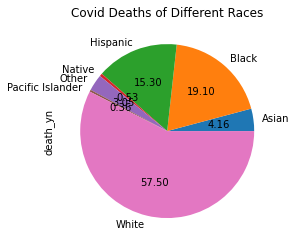

In [33]:
#plotting the pie chart
plot = pie_chart.plot.pie(y=pie_chart[1], autopct='%.2f',title="Covid Deaths of Different Races")

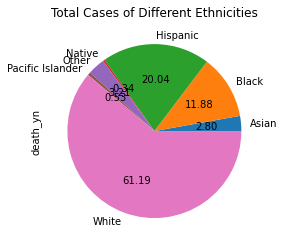

In [34]:
#displaying the percentage of total cases by ethnicity
plot = cases.plot.pie(y=pie_chart[1], autopct="%.2f", title="Total Cases of Different Ethnicities")

In [35]:
#building a bar graph of the cases and deaths to compare percentages
bar_df = pd.DataFrame(pie_chart)
bar_df['total cases'] = cases
bar_df

,death_yn,total cases
race_ethnicity_combined,,
Asian,1345.0,15839
Black,6180.0,67127
Hispanic,4950.0,113279
Native,172.0,1898
Other,988.0,18158
Pacific Islander,117.0,3002
White,18608.0,345821


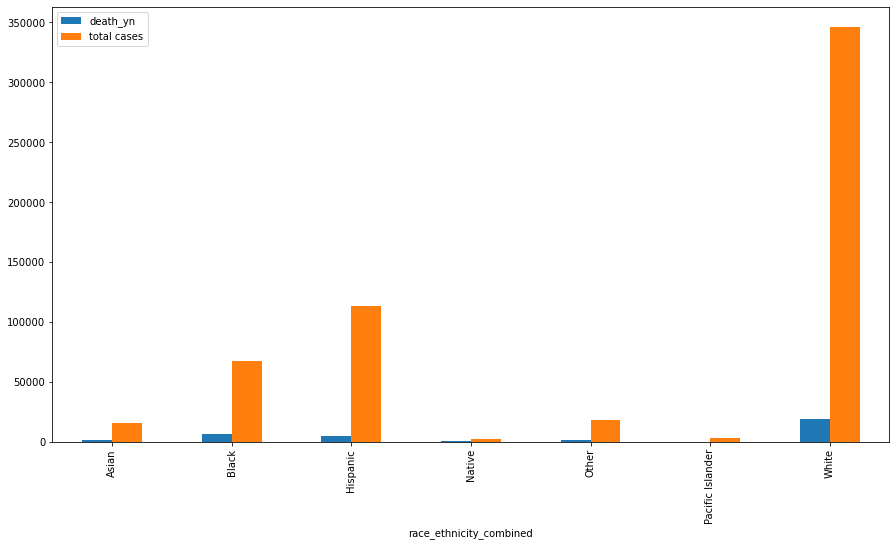

In [36]:
#displaying the bar graph
bar_graph = bar_df.plot.bar(figsize=(15,8))

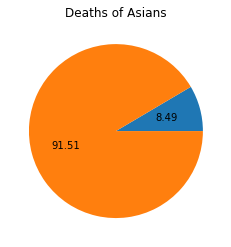

In [37]:
#survival rate of cases vs deaths for Asian people
pie_chart_asian = [bar_df['death_yn']['Asian'],
                   (bar_df['total cases']['Asian']-bar_df['death_yn']['Asian'])]
pie_chart_asian

plt.title("Deaths of Asians")
chart = plt.pie(pie_chart_asian,autopct='%.2f')

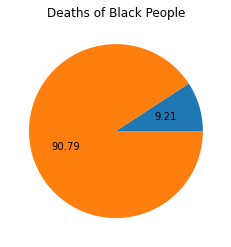

In [38]:
#survival rate of Black people
pie_chart_black = [bar_df['death_yn']['Black'],
                   (bar_df['total cases']['Black']-bar_df['death_yn']['Black'])]
pie_chart_black
plt.title("Deaths of Black People")
chart = plt.pie(pie_chart_black,autopct='%.2f')

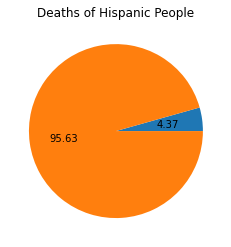

In [39]:
#survival rate of Hispanic people
pie_chart_hisp = [bar_df['death_yn']['Hispanic'],
                   (bar_df['total cases']['Hispanic']-bar_df['death_yn']['Hispanic'])]
pie_chart_hisp
plt.title('Deaths of Hispanic People')
chart = plt.pie(pie_chart_hisp,autopct='%.2f')

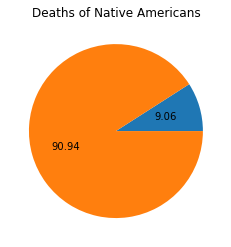

In [40]:
#survival rate of Native American people
pie_chart_native = [bar_df['death_yn']['Native'],
                   (bar_df['total cases']['Native']-bar_df['death_yn']['Native'])]
pie_chart_native
plt.title('Deaths of Native Americans')
chart = plt.pie(pie_chart_native,autopct='%.2f')

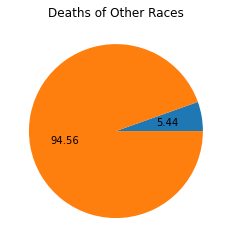

In [41]:
#survival rate of the group of people of other ethnicity
pie_chart_other = [bar_df['death_yn']['Other'],
                   (bar_df['total cases']['Other']-bar_df['death_yn']['Other'])]
pie_chart_other
plt.title("Deaths of Other Races")
chart = plt.pie(pie_chart_other,autopct='%.2f')

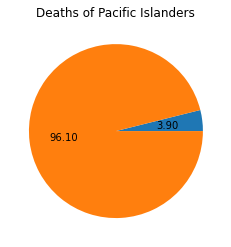

In [42]:
#suvival rate of Pacific Islander people
pie_chart_pac = [bar_df['death_yn']['Pacific Islander'],
                   (bar_df['total cases']['Pacific Islander']-bar_df['death_yn']['Pacific Islander'])]
pie_chart_pac
plt.title("Deaths of Pacific Islanders")
chart = plt.pie(pie_chart_pac,autopct='%.2f')

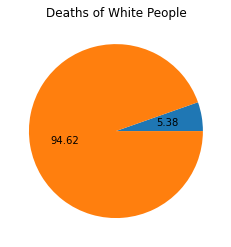

In [43]:
#survival rate of White people
pie_chart_white = [bar_df['death_yn']['White'],
                   (bar_df['total cases']['White']-bar_df['death_yn']['White'])]
pie_chart_white
plt.title("Deaths of White People")
chart = plt.pie(pie_chart_white,autopct='%.2f')

### Going through all the pie charts there are some interesting notes to take.
The deaths of Pacific Islanders in our data set are only 4.19% of the cases of Pacific Islanders.
White people, Hispanic people, and other races have a ~5-7% death rate in this data set, but native Americans and black people have a relatively high death rate of around 10%. This could be due to access to proper healthcare, but that wouldn't explain why hispanic people die less often than white people when white people more frequently have health insurance(1).
Perhaps hispanic people have different a different reaction to Covid-19 than other races, or perhaps culturally they treat their sick ones differently than other races.

1: https://www.statista.com/statistics/200970/percentage-of-americans-without-health-insurance-by-race-ethnicity/

In [44]:
#building a dataframe of months and different races deaths
#which I already did in my other file
time=file[['race_ethnicity_combined','month','death_yn']]

In [45]:
#putting together a dataframe of 
#information from the census and my findings
population_info = {"Ethnicity":['White','Hispanic','Black','Asian','Native American','Pacific Islander','Other'],
                  'Total Population':[200226109,60724311,43984096,12366132,4267114,656479,1969437],
                  'Percentage of US Population':[60.1,18.5,13.4,5.9,1.3,0.2,0.6],
                  'Percentage of Total Cases':[59.65,21.35,12.15,2.95,0.36,0.56,np.nan],
                  'Percentage of Total Deaths':[55.82,16.01,20.03,4.29,0.51,0.36,np.nan],
                  'Percentage of Ethnicity Reporting Covid':[0.136,0.16,0.126,0.0697,0.0385,0.062,np.nan]}
population_df = pd.DataFrame(population_info)
population_df

,Ethnicity,Total Population,Percentage of US Population,Percentage of Total Cases,Percentage of Total Deaths,Percentage of Ethnicity Reporting Covid
0,White,200226109,60.1,59.65,55.82,0.1360
1,Hispanic,60724311,18.5,21.35,16.01,0.1600
2,Black,43984096,13.4,12.15,20.03,0.1260
3,Asian,12366132,5.9,2.95,4.29,0.0697
4,Native American,4267114,1.3,0.36,0.51,0.0385
5,Pacific Islander,656479,0.2,0.56,0.36,0.0620
6,Other,1969437,0.6,NaN,NaN,NaN


# Percentages of populations
In this chart I wanted to collate some data I found both in my research and from the census. Since I noticed that hispanic people tend to survive more often I wanted to actually dig into the numbers a little bit. Here you can see that while hispanic people only account for 18.5% of the total US population, they had 21.35% of the cases of covid in our data set. Interestingly, they only have 16.01% of the deaths in our data set. Which is a lower percentage than that of their respective part of the total US population. So what we're seeing here is that hispanic people are suviving more than other races, despite being less insured.

Interestingly, Asian people have presumably been much more responsible about social distancing, as their percentage of the total cases is about half of their percentage of the total US population. 

Black people have been hit the hardest, with 20% of the total deaths from covid, while only making up 13.4% of the total population.

1: https://www.census.gov/quickfacts/fact/table/US/RHI725219

In [46]:
#building new dataframe for gender and race
genders = file[['sex','race_ethnicity_combined',"death_yn"]]
#getting the deaths of different races
ethnicity_gender = genders.groupby([genders['sex'],genders['race_ethnicity_combined']]).sum()
#getting the total cases of different races
ethnic_gender = genders.groupby([genders['sex'],genders['race_ethnicity_combined']]).count()
ethnic_gender = ethnic_gender.unstack()
ethnicity_with_gender = ethnicity_gender.unstack()
ethnicity_with_gender

death_yn                                 \
race_ethnicity_combined    Asian   Black Hispanic Native  Other   
sex                                                               
0.0                        512.0  2835.0   1672.0   81.0  384.0   
1.0                        833.0  3345.0   3278.0   91.0  604.0   

                                                   
race_ethnicity_combined Pacific Islander    White  
sex                                                
0.0                                 32.0   8276.0  
1.0                                 85.0  10332.0

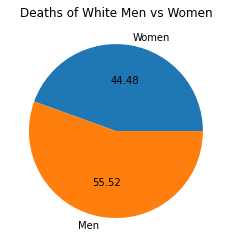

In [47]:
#displaying deaths of each gender of White people
white_genders = ethnicity_with_gender['death_yn']['White']
plt.title("Deaths of White Men vs Women")

chart = plt.pie(white_genders,autopct='%.2f',labels=("Women","Men"))

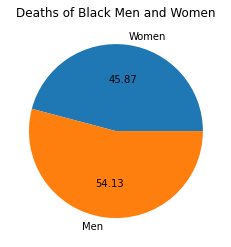

In [48]:
#displaying deaths of each gender of Black people
black_genders = ethnicity_with_gender['death_yn']['Black']
plt.title("Deaths of Black Men and Women")
chart = plt.pie(black_genders,autopct='%.2f',labels=("Women","Men"))

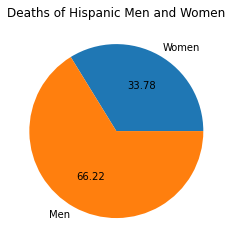

In [49]:
#displaying deaths of each gender of Hispanic people
hispanic_genders = ethnicity_with_gender['death_yn']['Hispanic']
plt.title("Deaths of Hispanic Men and Women")
chart = plt.pie(hispanic_genders,autopct='%.2f',labels=("Women","Men"))

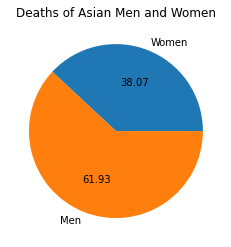

In [50]:
#displaying deaths of each gender of Asian people
asian_genders = ethnicity_with_gender['death_yn']['Asian']
plt.title("Deaths of Asian Men and Women")
chart = plt.pie(asian_genders,autopct='%.2f',labels=("Women","Men"))

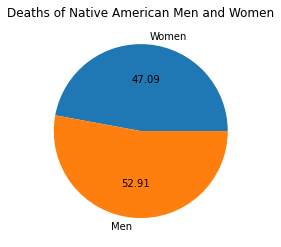

In [51]:
#displaying deaths of each gender of Native American people
native_genders = ethnicity_with_gender['death_yn']['Native']
plt.title("Deaths of Native American Men and Women")
chart = plt.pie(native_genders,autopct='%.2f',labels=("Women","Men"))

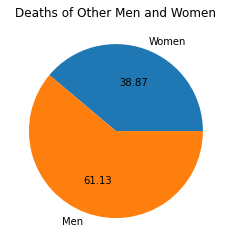

In [52]:
#displaying deaths of each gender of the other races
other_genders = ethnicity_with_gender['death_yn']['Other']
plt.title("Deaths of Other Men and Women")
chart = plt.pie(other_genders,autopct='%.2f',labels=("Women","Men"))

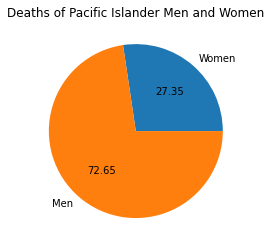

In [53]:
#displaying deaths of each gender of Pacific Islander people
pac_genders = ethnicity_with_gender['death_yn']['Pacific Islander']
plt.title("Deaths of Pacific Islander Men and Women")
chart = plt.pie(pac_genders,autopct='%.2f',labels=("Women","Men"))

### Some interesting things to note here.
White people and black people are pretty similar, with women being 60% more likely to survive than men. Pacific Islanders and hispanic people have vastly differing numbers, with women surviving around 70% more than men. This may be related to the fact that a higher percentage of women stay home than men, who tend to be more employed(1). This could also be cultural, especially the difference with Asian women vs men, as only 6.5% of Asian women are employed as of 2019(2).

1: https://work.chron.com/male-vs-female-statistics-workplace-america-23880.html

2: https://www.bls.gov/cps/cpsaat11.htm

In [54]:
#building dataframe for race with co-morbidity
#building new dataframe for co-morbidity and race
med = file[['medcond_yn','race_ethnicity_combined',"death_yn"]]
#getting the deaths of different races
ethnicity_med = med.groupby([med['medcond_yn'],med['race_ethnicity_combined']]).sum()
#getting the total cases of different races
ethnic_med = med.groupby([med['medcond_yn'],med['race_ethnicity_combined']]).count()
ethnic_med = ethnic_med.unstack()
ethnicity_with_med = ethnicity_med.unstack()
ethnic_med

death_yn                               \
race_ethnicity_combined    Asian  Black Hispanic Native Other   
medcond_yn                                                      
0.0                         8598  20867    62051    609  9621   
1.0                         7241  46260    51228   1289  8537   

                                                  
race_ethnicity_combined Pacific Islander   White  
medcond_yn                                        
0.0                                 1192  155389  
1.0                                 1810  190432

In [55]:
#these are the deaths of each race and
#whether or not they had pre-existing conditions
ethnicity_with_med

death_yn                                 \
race_ethnicity_combined    Asian   Black Hispanic Native  Other   
medcond_yn                                                        
0.0                         88.0   264.0    332.0   10.0   60.0   
1.0                       1257.0  5916.0   4618.0  162.0  928.0   

                                                   
race_ethnicity_combined Pacific Islander    White  
medcond_yn                                         
0.0                                 21.0   1309.0  
1.0                                 96.0  17299.0

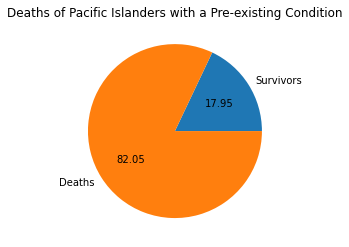

In [56]:
#survival rate of Pacific Islanders with
#a pre-existing medical condition
pac_med = ethnicity_with_med['death_yn']['Pacific Islander']
plt.title("Deaths of Pacific Islanders with a Pre-existing Condition")
chart = plt.pie(pac_med,autopct='%.2f',labels=("Survivors","Deaths"))

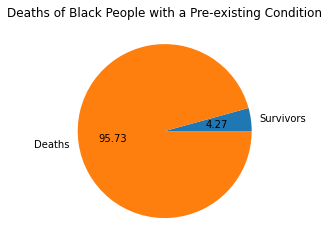

In [57]:
#survival rate of Black people with
#a pre-existing medical condition
black_med = ethnicity_with_med['death_yn']['Black']
plt.title("Deaths of Black People with a Pre-existing Condition")
chart = plt.pie(black_med,autopct='%.2f',labels=("Survivors","Deaths"))

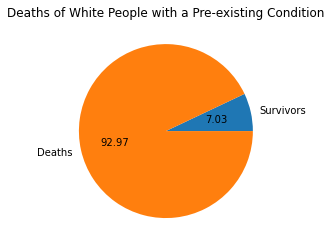

In [58]:
#survival rate of White people with
#a pre-existing medical condition
white_med = ethnicity_with_med['death_yn']['White']
plt.title("Deaths of White People with a Pre-existing Condition")
chart = plt.pie(white_med,autopct='%.2f',labels=("Survivors","Deaths"))

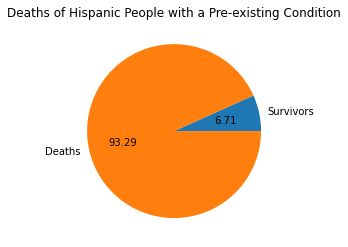

In [59]:
#survival rate of Hispanic pople with
#a pre-existing medical condition
hispanic_med = ethnicity_with_med['death_yn']['Hispanic']
plt.title("Deaths of Hispanic People with a Pre-existing Condition")
chart = plt.pie(hispanic_med,autopct='%.2f',labels=("Survivors","Deaths"))

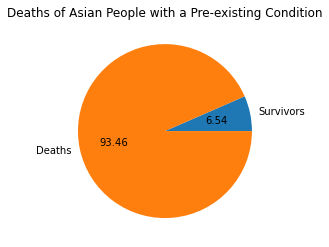

In [60]:
#survival rate of Asian people with
#a pre-existing medical condition
asian_med = ethnicity_with_med['death_yn']['Asian']
plt.title("Deaths of Asian People with a Pre-existing Condition")
chart = plt.pie(asian_med,autopct='%.2f',labels=("Survivors","Deaths"))

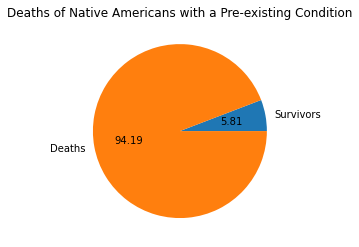

In [61]:
#survival rate of Native Americans with
#a pre-existing medical condition
native_med = ethnicity_with_med['death_yn']['Native']
plt.title("Deaths of Native Americans with a Pre-existing Condition")
chart = plt.pie(native_med,autopct='%.2f',labels=("Survivors","Deaths"))

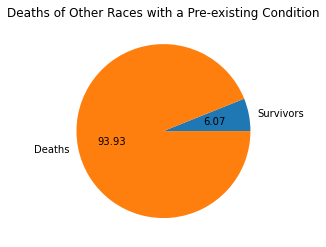

In [62]:
#survival rate of other people with
#a pre-existing medical condition
other_med = ethnicity_with_med['death_yn']['Other']
plt.title("Deaths of Other Races with a Pre-existing Condition")
chart = plt.pie(other_med,autopct='%.2f',labels=("Survivors","Deaths"))

## Here we see that pre-existing conditions is a MAJOR factor in survivability
It's interesting to note that Pacific Islanders with pre-existing conditions have such a higher survival rate than all of the other ethnic groups at 18.92.
Unfortunaly, we again see that black people have been hit hard by covid, with only 3.7% survivability with a pre-existing condition.
Everybody else has a survivability of around 6-7% with a pre-existing condition.

## Date of Contraction

In [63]:
#grouping the dataframe to compare time of first positive specimen with the age group
dates = file[['month','death_yn','age_group']]

#getting number of deaths
deaths = dates.groupby([dates['month'],dates['age_group']]).sum()
deaths = deaths.unstack()
deaths.head()

death_yn                                                          \
age_group 0 - 9 Years 10 - 19 Years 20 - 29 Years 30 - 39 Years 40 - 49 Years   
month                                                                           
1                 NaN           NaN           0.0           NaN           0.0   
2                 0.0           0.0           0.0           0.0           1.0   
3                 0.0           2.0          29.0         110.0         198.0   
4                 5.0          10.0          28.0          78.0         254.0   
5                 2.0           1.0          12.0          33.0          97.0   

                                                               
age_group 50 - 59 Years 60 - 69 Years 70 - 79 Years 80+ Years  
month                                                          
1                   0.0           0.0           0.0       NaN  
2                   3.0           4.0           4.0       5.0  
3                 489.0         734.0         708.0     654.0  
4                 750.0        1295.0        1295.0    1873.0  
5                 278.0         611.0         846.0    1557.0

<AxesSubplot:title={'center':'Deaths of Different Age Groups Over Time'}, xlabel='month'>

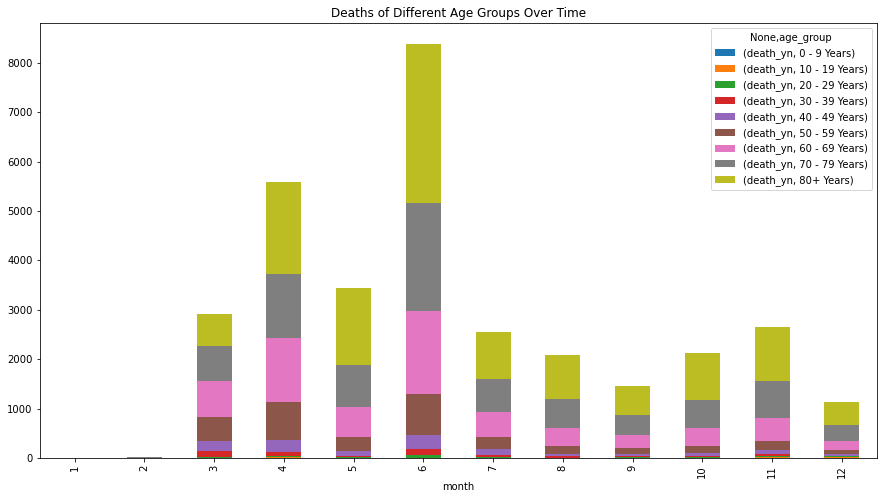

In [64]:
#graphing the deaths of each agegroup for each month
deaths.plot.bar(stacked=True, figsize = (15,8),
                title="Deaths of Different Age Groups Over Time",)

### Here we can see that older people are dying with much more frequency than younger people, and that the older a patient is, the more likely they are to die.

In [65]:
#counting the total reported cases in each age group for each month
total_cases = dates.groupby([dates['month'],dates['age_group']]).count()
total_cases = total_cases.unstack()
total_cases = total_cases.rename(columns={"death_yn":'cases'})
total_cases

cases                                                          \
age_group 0 - 9 Years 10 - 19 Years 20 - 29 Years 30 - 39 Years 40 - 49 Years   
month                                                                           
1                 NaN           NaN           3.0           NaN           3.0   
2                 1.0           1.0           3.0           6.0          13.0   
3                49.0         176.0        1045.0        1368.0        1632.0   
4               336.0         823.0        3891.0        4601.0        4956.0   
5               819.0        1776.0        5232.0        5658.0        5572.0   
6              1459.0        3114.0        7804.0        7132.0        7031.0   
7              2185.0        6006.0       13307.0       10255.0        9480.0   
8              2038.0        6986.0       12996.0        9208.0        8961.0   
9              1859.0        8112.0       11218.0        6879.0        6864.0   
10             2885.0        9236.0       13157.0       11006.0       11163.0   
11             4299.0       12198.0       17009.0       16020.0       16058.0   
12             3090.0        7440.0       10380.0        9888.0        9574.0   

                                                               
age_group 50 - 59 Years 60 - 69 Years 70 - 79 Years 80+ Years  
month                                                          
1                   6.0           1.0           1.0       NaN  
2                  16.0          12.0          12.0      10.0  
3                2250.0        2217.0        1467.0    1045.0  
4                6138.0        5402.0        3319.0    3398.0  
5                6000.0        4489.0        2870.0    3440.0  
6                7381.0        6314.0        4752.0    4932.0  
7                9297.0        6751.0        3976.0    2635.0  
8                9132.0        6886.0        4148.0    2839.0  
9                7244.0        5520.0        3662.0    2203.0  
10              11808.0        9657.0        6053.0    3736.0  
11              16481.0       13316.0        8329.0    4836.0  
12              10011.0        8614.0        5229.0    3028.0

<AxesSubplot:title={'center':'Total Cases Over Time'}, xlabel='month'>

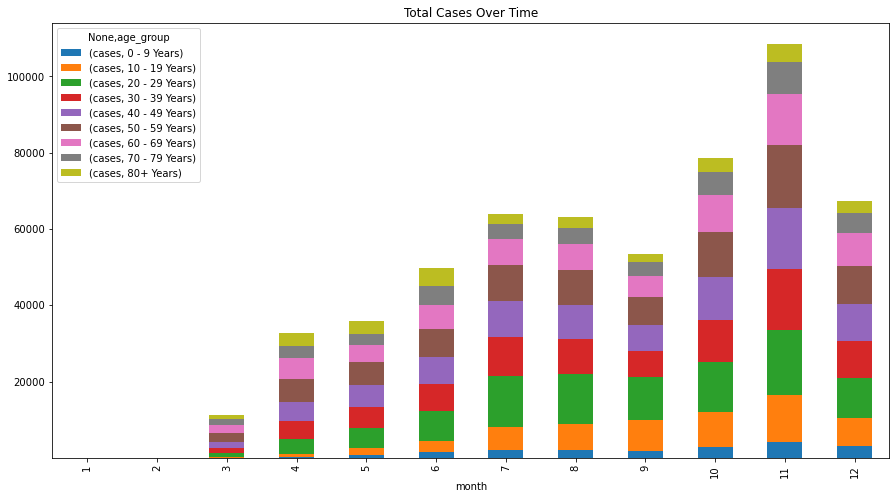

In [66]:
#graphing total cases
total_cases.plot.bar(stacked=True, figsize = (15,8),
                    title="Total Cases Over Time")

### Here we can see that younger people are contracting the disease a lot more frequently than older people.
This would likely be due to the social nature of younger people, and the fact that many younger people absolutely need to work to survive. There have been reports(1) about how millenials have much less money saved than other generations had at our age, which would have a prime factor on survivability during lockdown.


!: https://www.businessinsider.com/average-american-millennial-net-worth-student-loan-debt-savings-habits-2019-6#and-the-typical-millennial-has-less-than-5000-in-their-savings-account-3

In [67]:
#grouping dataframe to compare time of first positive with gender
gender_dates = file[['month','death_yn','sex']]

#getting number of deaths
gender_deaths = gender_dates.groupby([gender_dates['month'],gender_dates['sex']]).sum()
gender_deaths = gender_deaths.unstack()
gender_deaths

death_yn        
sex        0.0     1.0
month                 
1          0.0     0.0
2          6.0    11.0
3       1028.0  1896.0
4       2338.0  3250.0
5       1622.0  1815.0
6       3557.0  4825.0
7       1112.0  1444.0
8        944.0  1145.0
9        635.0   815.0
10       934.0  1191.0
11      1118.0  1544.0
12       498.0   632.0

<AxesSubplot:title={'center':'Deaths of Different Genders Over Time'}, xlabel='month'>

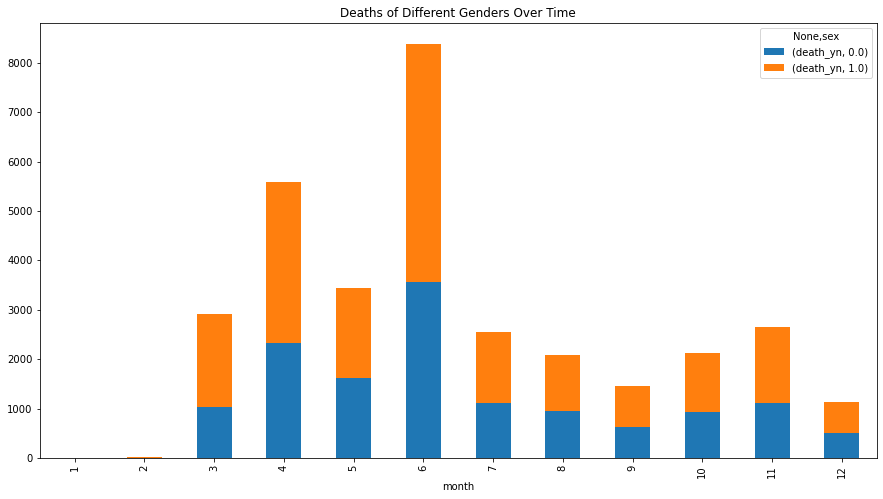

In [68]:
#graphing deaths of each gender by month
gender_deaths.plot.bar(stacked=True, figsize = (15,8),
                      title="Deaths of Different Genders Over Time")

### Here we can see that women tend to survive more often than men, and that over time the balance between the two hasn't really shifted much

In [69]:
#grouping the dataframe to compare time of first positive specimen with the ethnicity
ethnicity_dates = file[['month','death_yn','race_ethnicity_combined']]

#getting number of deaths
ethnicity_deaths = ethnicity_dates.groupby([ethnicity_dates['month'],ethnicity_dates['race_ethnicity_combined']]).sum()
ethnicity_deaths = ethnicity_deaths.unstack()
ethnicity_deaths

death_yn                                 \
race_ethnicity_combined    Asian   Black Hispanic Native  Other   
month                                                             
1                            0.0     0.0      0.0    NaN    NaN   
2                            0.0     6.0      5.0    NaN    0.0   
3                          195.0   781.0    761.0    2.0  147.0   
4                          235.0  1137.0   1065.0   13.0  295.0   
5                          126.0   606.0    343.0   35.0  121.0   
6                          466.0  1901.0   1641.0   23.0  117.0   
7                           98.0   634.0    405.0   25.0   53.0   
8                           54.0   324.0    195.0   15.0   35.0   
9                           38.0   198.0    119.0   15.0   26.0   
10                          39.0   237.0    132.0   20.0   44.0   
11                          58.0   258.0    203.0   17.0   95.0   
12                          36.0    98.0     81.0    7.0   55.0   

                                                  
race_ethnicity_combined Pacific Islander   White  
month                                             
1                                    NaN     0.0  
2                                    NaN     6.0  
3                                    6.0  1032.0  
4                                   11.0  2832.0  
5                                   26.0  2180.0  
6                                   23.0  4211.0  
7                                   16.0  1325.0  
8                                   13.0  1453.0  
9                                    8.0  1046.0  
10                                   4.0  1649.0  
11                                   8.0  2023.0  
12                                   2.0   851.0

<AxesSubplot:title={'center':'Deaths of Different Ethnicities Over Time'}, xlabel='month'>

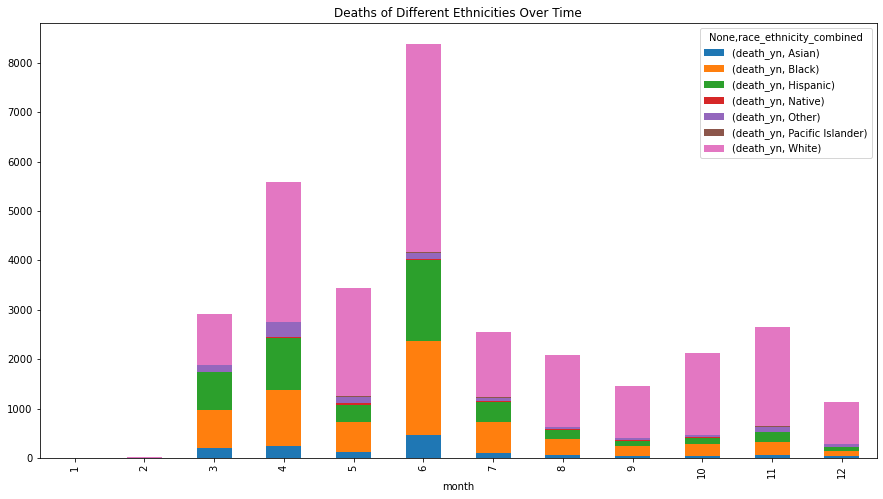

In [70]:
#graphing the number of deaths per race
ethnicity_deaths.plot.bar(stacked=True, figsize = (15,8),
                         title="Deaths of Different Ethnicities Over Time")

### Here we can see that the distribution of deaths among different racial groups is mostly white, but that's probably because white people are more than 60% percent of the American population.

In [71]:
#grouping the dataframe to compare time of first positive specimen with the ethnicity
ethnicity_dates = file[['month','death_yn','race_ethnicity_combined']]

#getting number of cases
ethnicity_cases = ethnicity_dates.groupby([ethnicity_dates['month'],ethnicity_dates['race_ethnicity_combined']]).count()
ethnicity_cases = ethnicity_cases.unstack()
ethnicity_cases = ethnicity_cases.rename(columns={"death_yn":'cases'})
ethnicity_cases

cases                                   \
race_ethnicity_combined   Asian    Black Hispanic Native   Other   
month                                                              
1                           4.0      2.0      2.0    NaN     NaN   
2                           6.0     15.0     16.0    NaN     2.0   
3                         509.0   2257.0   2377.0   29.0   468.0   
4                        1255.0   5584.0   8757.0   91.0  1432.0   
5                        1995.0   6005.0  11067.0  201.0  1293.0   
6                        2127.0   7662.0  17650.0  191.0   972.0   
7                        1734.0  10964.0  17247.0  245.0  1845.0   
8                        1547.0   6743.0  11444.0  289.0  1852.0   
9                        1371.0   4760.0   7515.0  177.0  1689.0   
10                       1575.0   6215.0  11806.0  240.0  2268.0   
11                       2403.0   9566.0  16656.0  316.0  3557.0   
12                       1313.0   7354.0   8742.0  119.0  2780.0   

                                                   
race_ethnicity_combined Pacific Islander    White  
month                                              
1                                    NaN      6.0  
2                                    NaN     35.0  
3                                   48.0   5561.0  
4                                  103.0  15642.0  
5                                  293.0  15002.0  
6                                  521.0  20796.0  
7                                  487.0  31370.0  
8                                  329.0  40990.0  
9                                  187.0  37862.0  
10                                 372.0  56225.0  
11                                 494.0  75554.0  
12                                 168.0  46778.0

<AxesSubplot:title={'center':'Cases of Different Ethnic Groups Over Time'}, xlabel='month'>

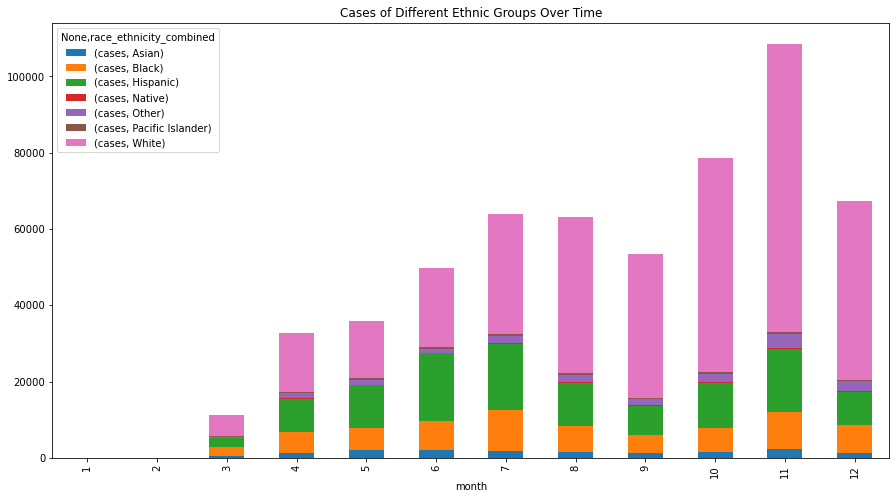

In [72]:
#graphing the number of cases per ethnic group
ethnicity_cases.plot.bar(stacked=True, figsize = (15,8),
                        title="Cases of Different Ethnic Groups Over Time")

## Now to see if there's a correlation between hospital occupancy of covid patients and death

In [73]:
#grouping the dataframe to compare time of first positive specimen with the age group
dates = file[['month','death_yn']]
#dates
#getting number of deaths
deaths = dates.groupby('month').sum()
# deaths = deaths.unstack()
#deaths
occupancy = file[['month', 'percent_of_inpatients_with_covid']]
occupancy = occupancy.groupby('month').mean()
occupancy.index
deaths['percent_of_inpatients_with_covid'] = occupancy['percent_of_inpatients_with_covid']
deaths

,death_yn,percent_of_inpatients_with_covid
month,,
1,0.0,0.000000
2,17.0,0.004861
3,2924.0,0.067229
4,5588.0,0.148326
5,3437.0,0.111960
6,8382.0,0.078412
7,2556.0,0.105063
8,2089.0,0.087548
9,1450.0,0.068433


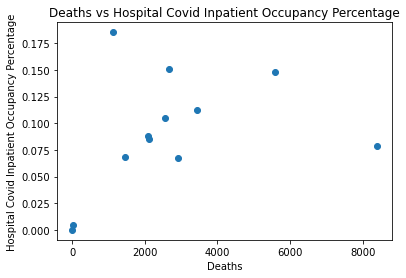

In [74]:
plt.title("Deaths vs Hospital Covid Inpatient Occupancy Percentage")
plt.xlabel("Deaths")
plt.ylabel("Hospital Covid Inpatient Occupancy Percentage")
plt.scatter(deaths['death_yn'],deaths['percent_of_inpatients_with_covid'])

In [75]:
correlation = st.pearsonr(deaths['death_yn'],deaths['percent_of_inpatients_with_covid'])
correlation

(0.3255008083609431, 0.30186621103061795)

### That's a pretty low correlation coefficient
Being as that is the case there isn't really a strong correlation between hospital occupancy of covid inpatients and death over the year

# Next up, let's look at whether or not the patient was put in ICU, and if that was effective at preventing death over the year

In [76]:
#grouping the dataframe to compare time of first positive specimen with the age group
dates = file[['month','death_yn']]
#dates
#getting number of deaths
deaths = dates.groupby('month').sum()
# deaths = deaths.unstack()
#deaths
occupancy = file[['month', 'icu_yn']]
occupancy = occupancy.groupby('month').sum()
occupancy.index
deaths['icu_yn'] = occupancy['icu_yn']
deaths

,death_yn,icu_yn
month,,
1,0.0,3.0
2,17.0,19.0
3,2924.0,3120.0
4,5588.0,5042.0
5,3437.0,3100.0
6,8382.0,6398.0
7,2556.0,3380.0
8,2089.0,2362.0
9,1450.0,1768.0


<AxesSubplot:title={'center':'Deaths Compared to ICU Occupancy Over Time'}, xlabel='month'>

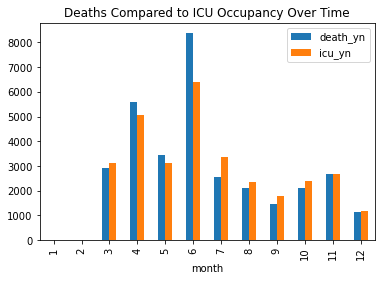

In [77]:
deaths.plot.bar(title='Deaths Compared to ICU Occupancy Over Time')

### Here we can see that in the early months of the pandemic, there were more deaths than ICU occupants. 
Especially in June, when there was a surge of cases and deaths. Perhaps over time our medical community learned how to better treat covid patients. It's obvious that people were being sent to the ICU but they maybe just didn't know the signs of when a patient needed to go to the ICU. It appears that as time went on, there were not only less deaths, but higher numbers of patients in the ICU than dying, which would suggest that the treatments being recieved in the ICU are working.

## Hospital Capacity

### Is there a relationship between the COVID-19 admittances /hospital in-patient capacity ratio to COVID mortality rates?

In [78]:
# Read Data file
df = pd.read_csv('./Data/clean_data.csv')

# Display header to get a sense of look and feel
df.head(2)

#Define Month Grouping
grp_stats = df.groupby(['month'])

grp_stats.count().head(2)

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn,inpatient__occupancy,percent_of_inpatients_with_covid
month,,,,,,,,,,,,,,
1,14,14,14,14,14,14,14,14,14,14,14,14,14,14
2,74,74,74,74,74,74,74,74,74,74,74,74,74,74


In [79]:
#Calculate Death & Covid inpatients Stats per month

# Sum on Death 
sum_dth = grp_stats["death_yn"].sum()

# Total Population Count
totalcnt = grp_stats["death_yn"].count()

#Average Percent of deaths
pct_dth = sum_dth/totalcnt

#Average Covid inpatient percentage
covid_inpatient_pct = grp_stats["percent_of_inpatients_with_covid"].mean()


#Create a dataframe to enable statistical regression and plotting
grp_stats_df = pd.DataFrame({"In Patient Pct" : covid_inpatient_pct,
                             "Dth_Rate" : pct_dth
                             })
grp_stats_df

,In Patient Pct,Dth_Rate
month,,
1,0.000000,0.000000
2,0.004861,0.229730
3,0.067229,0.259934
4,0.148326,0.170034
5,0.111960,0.095856
6,0.078412,0.167912
7,0.105063,0.040005
8,0.087548,0.033057
9,0.068433,0.027072


In [80]:
#Set today's date as a variable
date = pd.to_datetime("today").strftime("%m/%d/%Y")

#Calculate correlation coefficient
Correlation_Coef = round(st.pearsonr(grp_stats_df['In Patient Pct'],grp_stats_df['Dth_Rate'])[0],5)
Correlation_Coef

#Calulate linear formula
x_values = grp_stats_df['In Patient Pct']
y_values = grp_stats_df['Dth_Rate']

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

#Record results in a dataframe
linear_formula_Df = pd.DataFrame({
    "Corr Analysis":"In Patient Pct vs Dth_Rate",
    "Slope":slope,
    "Intercept":intercept,
    "rValueCorr_Coef":rvalue,
    "PndasCorr_Coef":Correlation_Coef,
    "StdErr":stderr 
} ,index=[0] )
linear_formula_Df

,Corr Analysis,Slope,Intercept,rValueCorr_Coef,PndasCorr_Coef,StdErr
0,In Patient Pct vs Dth_Rate,-0.409888,0.128331,-0.246572,-0.24657,0.509449


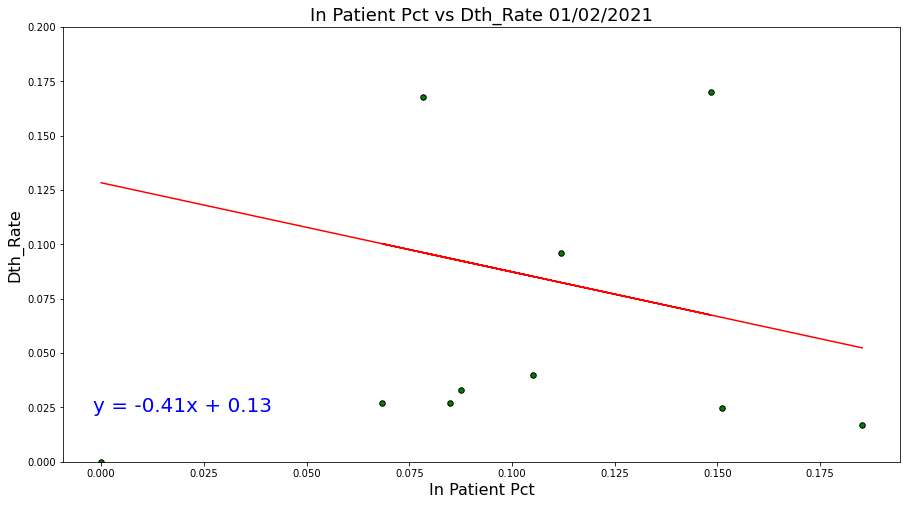

In [81]:
#Create text for plot overlay
line_equation = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
line_equation

#Plot the linear regression model on top of the scatter plot

# Generate a scatter plot of Max Temp vs. Latitude
# Add the linear regreassion and line to the plot

#Charactorize figure size/layout                       
fig1, ax1 = plt.subplots(figsize=(15, 8))

#Build and format scatter plot based on mean values drawn from the clean_weather_data_df dataframe
plt.scatter(grp_stats_df['In Patient Pct'],grp_stats_df['Dth_Rate'],s=30, edgecolors='black', color="green")

#define title and Lable axis
plt.title('In Patient Pct vs Dth_Rate '+date,fontsize =18)
plt.xlabel('In Patient Pct',fontsize =16)
plt.ylabel('Dth_Rate',fontsize =16)
marker_size = 12

#Establish plot limits
plt.ylim(0, .2)

# Add plot and text of linear regression model 
plt.plot(x_values,regress_values,"r-")
ax1.annotate(line_equation, xy=(.08, .12), xycoords='data',xytext=(0.25, 0.15), textcoords='axes fraction',
             horizontalalignment='right', verticalalignment='top',fontsize=20,color="blue")


#Save image for potential reference in the report
plt.savefig("./Images/Plots/In Patient Pct vs Dth_Rate.png")

plt.show()

We performed a regression analysis using our hospitalization data to compare the COVID-19 admittances/hospital capacity ratio to COVID mortality rates to see if it would provide us an indicator to help guide in targeting the most vulnerable population to receive the vaccination. 
The regression results showed a relatively low correlation coefficient and, as the hospitalization data set otherwise had numerous significant data gaps, we opted not to pursue this further.

### What trends in mortality rates and COVID Admittances were observed by month? 

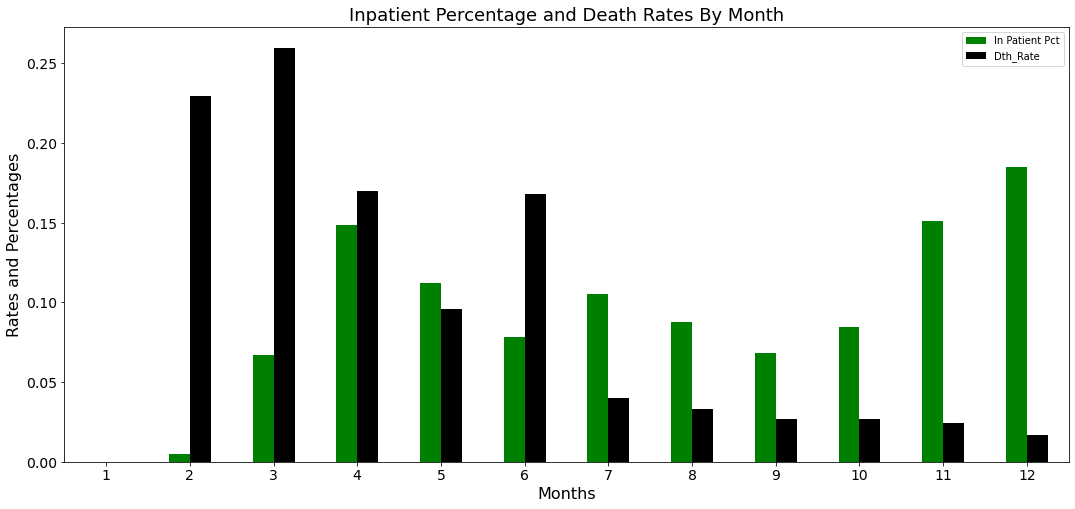

In [82]:
# Generate a bar plot showing the inpatient percentage and death rates by month using pandas.

#Plot Chart
measure_plot = grp_stats_df.plot.bar(figsize=(18,8), color= ['green', 'black'],fontsize = 14)
plt.xlabel("Months",fontsize = 16)
plt.ylabel("Rates and Percentages",fontsize = 16)
plt.title("Inpatient Percentage and Death Rates By Month",fontsize = 18)
plt.xticks(rotation=0)


#Save image for potential reference in the report
plt.savefig("./Images/Plots/inpatient_pct_and_dth_rte_plot_by_mnth.png")

plt.show()

We found that early on, there was an extremely high mortality rate versus admissions. A declining mortality rate for the remainder of the year  was observed ending with November reporting 1.5%. 
We noted that even as admissions went up in the latter months (September - November), the mortality rates continued to decline
We attribute the early high percentage rates to the low amount of testing and suggest that the latter months of our data may be more reliable for interpretive use as they appear to be more comprehensive.

In [83]:
df = pd.read_csv('./Data/clean_data.csv')

# Display header to get a sense of look and feel
df.head(2)

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn,month,inpatient__occupancy,percent_of_inpatients_with_covid
0,2020/03/22,2020/03/22,2020/03/23,2020/03/22,Laboratory-confirmed case,0.0,0 - 9 Years,Hispanic,0.0,0.0,0.0,0.0,3,0.518818,0.067229
1,2020/03/22,2020/03/26,2020/03/23,2020/03/22,Laboratory-confirmed case,1.0,0 - 9 Years,White,1.0,0.0,0.0,1.0,3,0.518818,0.067229


In [84]:
#Define Month Grouping
grp_stats = df.groupby(['month'])

grp_stats.count().head(2)

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn,inpatient__occupancy,percent_of_inpatients_with_covid
month,,,,,,,,,,,,,,
1,14,14,14,14,14,14,14,14,14,14,14,14,14,14
2,74,74,74,74,74,74,74,74,74,74,74,74,74,74


In [85]:
#Calculate Death & Covid inpatients Stats per month

# count on number of cases reported
cnt_reported = grp_stats["cdc_report_dt"].count()

# Total Population Count
totalcnt = len(df)

# Sum on Death 
sum_dth = grp_stats["death_yn"].sum()

#Death Count per Case Count
dth_cnt_per_cs_cnt = sum_dth/cnt_reported

#Create month array for plotting
month_list = df['month'].unique()
month_list.sort()


#Create a dataframe to enable statistical regression and plotting
grp_stats_df = pd.DataFrame({"Case Count Reported" : cnt_reported,
                             "Death Count Reported" : sum_dth,
                             "Death % of Case Count" :dth_cnt_per_cs_cnt,                                                     
                             })
grp_stats_df

,Case Count Reported,Death Count Reported,Death % of Case Count
month,,,
1,14,0.0,0.000000
2,74,17.0,0.229730
3,11249,2924.0,0.259934
4,32864,5588.0,0.170034
5,35856,3437.0,0.095856
6,49919,8382.0,0.167912
7,63892,2556.0,0.040005
8,63194,2089.0,0.033057
9,53561,1450.0,0.027072


### What trending in case occurrence was observed by month?

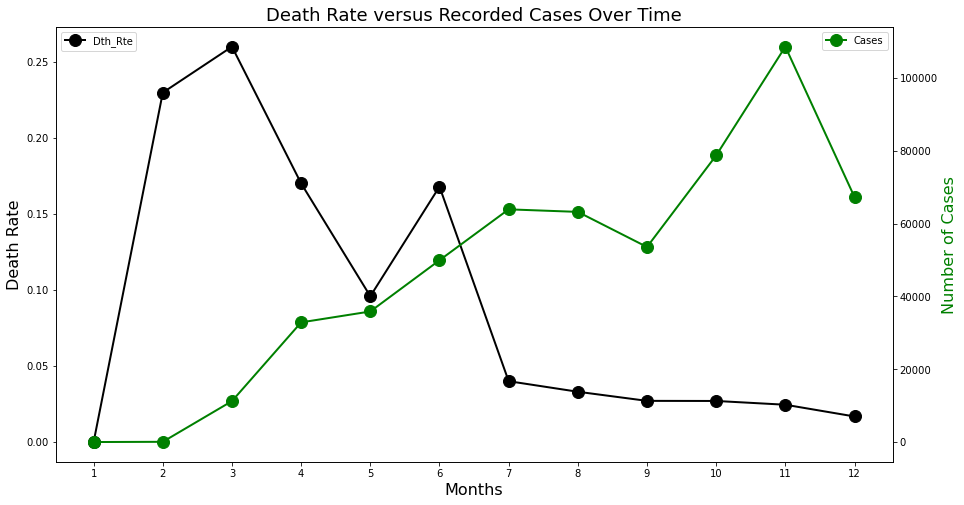

In [86]:
# Generate a line plot of death rate per recorded case over time

#Define plot components
x_axis = month_list
dth_pct_case_cnt = grp_stats_df["Death % of Case Count"]
cse_cnt_rptd = grp_stats_df["Case Count Reported"]


#Charactorize figure size/layout                       
fig = plt.figure(figsize=(15, 8))

#Build and format plot 1
ax1 = fig.add_subplot(111)
ax1.plot(x_axis, dth_pct_case_cnt, linewidth=2, markersize=12,marker="o",color="black", label = "Dth_Rte")
plt.xlabel('Months',fontsize =16)
plt.ylabel('Death Rate',fontsize =16)
plt.legend(loc='upper left')

#Build and format plot 2
ax2=ax1.twinx()
ax2.plot(x_axis, cse_cnt_rptd, linewidth=2, markersize=12,marker="o",color="green", label = "Cases")
plt.legend(loc='upper right')
plt.ylabel('Number of Cases',color="green",fontsize =16)

#define title and Lable axis
plt.title('Death Rate versus Recorded Cases Over Time',fontsize =18)

plt.xticks(x_axis)

#Establish plot limits
#plt.ylim(-.02, .3)

#Save image for potential reference in the report
plt.savefig("./Images/Plots/dth_rte_per_recorded_case_over_time", bbox_inches = "tight")

plt.show()

We observed case occurrences with death rate as an overlay.
As with the COVID admissions to mortality plot viewed previously, we found early on, there was an extremely high mortality rate versus admissions. Then a declining mortality rate for the remainder of the year ending in November at 1.5%. 
We noted that even as recorded COVID cases went up, in the latter months (September - November), the mortality rates continued to decline
We attribute the early high percentage rates to the low amount of testing and suggest that the latter months of our data may be more reliable for interpretive use as they appear to be more comprehensive.

In [87]:
#Define age grouping 11th month only
df_11 = df.loc[df["month"] == 11,:]

grp_age_stats = df_11.groupby(['age_group','month'])

grp_age_stats.count().head(2)

#Age Calculations
# Sum on Death 
sum_age_dth = grp_age_stats["death_yn"].sum()


#Create a dataframe to enable statistical regression and plotting
grp_stats_age_df = pd.DataFrame({"Age at Death" : sum_age_dth                             
                             })
grp_stats_age_df

,,Age at Death
age_group,month,
0 - 9 Years,11,3.0
10 - 19 Years,11,15.0
20 - 29 Years,11,23.0
30 - 39 Years,11,37.0
40 - 49 Years,11,93.0
50 - 59 Years,11,181.0
60 - 69 Years,11,457.0
70 - 79 Years,11,751.0
80+ Years,11,1102.0


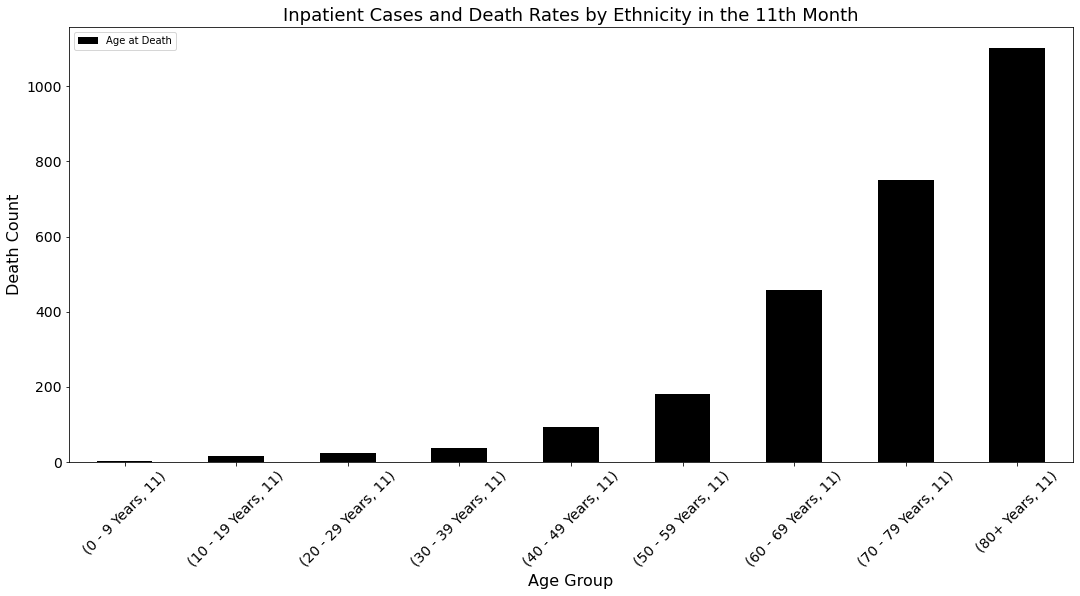

In [88]:
# Generate a bar plot showing the Inpatient Cases and Death Rates by Ethnicity in the 11th Month

#Plot Chart

measure_plot = grp_stats_age_df.plot.bar(figsize=(18,8), color= ['black'],fontsize = 14)
plt.xlabel("Age Group",fontsize = 16)
plt.ylabel("Death Count",fontsize = 16)
plt.title("Inpatient Cases and Death Rates by Ethnicity in the 11th Month",fontsize = 18)
plt.xticks(rotation=45)


#Save image for potential reference in the report
plt.savefig("./Images/Plots/dth_cnt_by_age_grp_plot_by_mnth.png")

plt.show()

In [89]:
#Define Ethnic grouping 11th month only
df_11 = df.loc[df["month"] == 11,:]

grp_ethnic_stats = df_11.groupby(['race_ethnicity_combined','month'])

grp_ethnic_stats.count().head(2)

,,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,hosp_yn,icu_yn,death_yn,medcond_yn,inpatient__occupancy,percent_of_inpatients_with_covid
race_ethnicity_combined,month,,,,,,,,,,,,,
Asian,11,2403,2403,2403,2403,2403,2403,2403,2403,2403,2403,2403,2403,2403
Black,11,9566,9566,9566,9566,9566,9566,9566,9566,9566,9566,9566,9566,9566


In [90]:
#Age Calculations
# Sum on Death 
sum_ethnic_dth = grp_ethnic_stats["death_yn"].sum()

#Count of reported
cnt_ethnic_rptd = grp_ethnic_stats["cdc_report_dt"].count()

#Ratio of death to reported
dth_rate_by_ethnicity = sum_ethnic_dth/cnt_ethnic_rptd

#Create a dataframe to enable statistical regression and plotting
grp_stats_ethnic_df = pd.DataFrame({"Cases Reported":cnt_ethnic_rptd,
                                    "Pct of Reported Dying":dth_rate_by_ethnicity                                    
                             })
grp_stats_ethnic_df

,,Cases Reported,Pct of Reported Dying
race_ethnicity_combined,month,,
Asian,11,2403,0.024136
Black,11,9566,0.026971
Hispanic,11,16656,0.012188
Native,11,316,0.053797
Other,11,3557,0.026708
Pacific Islander,11,494,0.016194
White,11,75554,0.026776


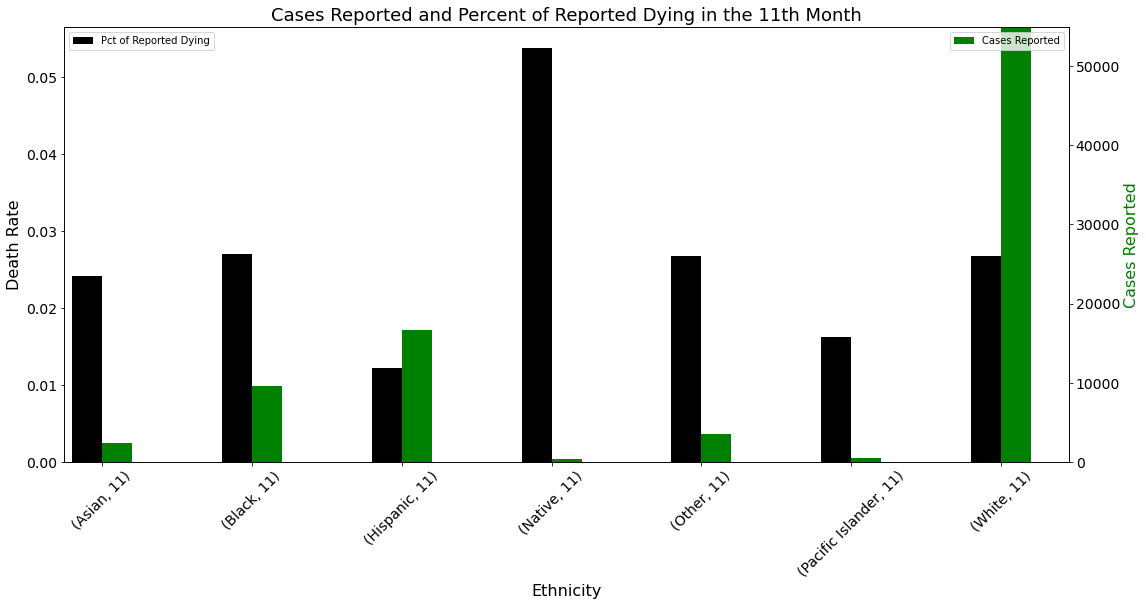

In [91]:
# Generate a bar plot showing the cases reported and percent of reported dying

#Plot Chart
fig = plt.figure(figsize=(15, 8))

width=0.2

#Build and format plot 1
ax1 = fig.add_subplot(111)
grp_stats_ethnic_df['Pct of Reported Dying'].plot.bar(figsize=(18,8), color= ['black'],fontsize = 14, position=1,width=width)
plt.xlabel('Ethnicity',fontsize =16)
plt.ylabel('Death Rate',fontsize =16)
plt.legend(loc='upper left')
plt.xticks(rotation=45)

#Build and format plot 2
ax2=ax1.twinx()
grp_stats_ethnic_df['Cases Reported'].plot.bar(figsize=(18,8), color= ['green'],fontsize = 14, position=0,width=width)
plt.legend(loc='upper right')
plt.ylabel('Cases Reported',color="green",fontsize =16)
plt.ylim(0, 55000)

#define title and Lable axis
plt.title("Cases Reported and Percent of Reported Dying in the 11th Month",fontsize = 18)



#Save image for potential reference in the report
plt.savefig("./Images/Plots/cases_rptd_and_pct_rptd_dth_by_ethnic_grp.png")

plt.show()

# 3. Regression Analysis

In [92]:
# Import dataset

df = pd.read_csv('Data/clean_data.csv')
df.head()

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn,month,inpatient__occupancy,percent_of_inpatients_with_covid
0,2020/03/22,2020/03/22,2020/03/23,2020/03/22,Laboratory-confirmed case,0.0,0 - 9 Years,Hispanic,0.0,0.0,0.0,0.0,3,0.518818,0.067229
1,2020/03/22,2020/03/26,2020/03/23,2020/03/22,Laboratory-confirmed case,1.0,0 - 9 Years,White,1.0,0.0,0.0,1.0,3,0.518818,0.067229
2,2020/03/22,2020/03/22,2020/03/23,2020/03/22,Laboratory-confirmed case,1.0,0 - 9 Years,White,0.0,0.0,0.0,0.0,3,0.518818,0.067229
3,2020/03/23,2020/03/27,2020/03/24,2020/03/23,Laboratory-confirmed case,0.0,0 - 9 Years,Other,0.0,0.0,0.0,0.0,3,0.518818,0.067229
4,2020/03/21,2020/03/21,2020/03/24,2020/03/21,Laboratory-confirmed case,0.0,0 - 9 Years,White,0.0,0.0,0.0,1.0,3,0.518818,0.067229


## Dummy Variable Classification
Dummy variables are a great way to let the regression software do the heavy lifting in the analysis of causal factors 

The underlying math is actually the same as a groupby average, but it gives our results in terms of regression coefficients, so we can very easily use them to estimate the future

https://conjointly.com/kb/dummy-variables/

In [93]:
# pandas.get_dummies is custom-built for this

# Age:
ageDummies = pd.get_dummies(df['age_group'])
df = pd.merge(df, ageDummies, left_index=True, right_index=True)

# Ethnicity:
ethnoDummies = pd.get_dummies(df['race_ethnicity_combined'])
df = pd.merge(df, ethnoDummies, left_index=True, right_index= True)

df.head()


,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,...,60 - 69 Years,70 - 79 Years,80+ Years,Asian,Black,Hispanic,Native,Other,Pacific Islander,White
0,2020/03/22,2020/03/22,2020/03/23,2020/03/22,Laboratory-confirmed case,0.0,0 - 9 Years,Hispanic,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,2020/03/22,2020/03/26,2020/03/23,2020/03/22,Laboratory-confirmed case,1.0,0 - 9 Years,White,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,2020/03/22,2020/03/22,2020/03/23,2020/03/22,Laboratory-confirmed case,1.0,0 - 9 Years,White,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,2020/03/23,2020/03/27,2020/03/24,2020/03/23,Laboratory-confirmed case,0.0,0 - 9 Years,Other,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,2020/03/21,2020/03/21,2020/03/24,2020/03/21,Laboratory-confirmed case,0.0,0 - 9 Years,White,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [94]:
#REGRESSION: LINEAR PROBABILITY MODEL

# Define input variables
x = df[['sex', 'medcond_yn', '0 - 9 Years', '10 - 19 Years', '20 - 29 Years',
       '30 - 39 Years', '40 - 49 Years', '50 - 59 Years', '60 - 69 Years',
       '70 - 79 Years', '80+ Years', 'Native', 'Asian','Black', 'Hispanic',
       'Other','Pacific Islander','White']]
x = sm.add_constant(x)
# Avoid perfect multicollinearity (comment out these two lines and you'll see that it breaks the regression)
del x['0 - 9 Years']
del x['White']

# Define output variable (death)
y = df['death_yn']

# Ordinary Least Squares Regression
model = sm.OLS(y, x, hasconst= True)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               death_yn   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     7995.
Date:                Sat, 02 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:19:57   Log-Likelihood:                 80607.
No. Observations:              565124   AIC:                        -1.612e+05
Df Residuals:                  565107   BIC:                        -1.610e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0423      0.002    -26.581      0.000      -0.045      -0.039
sex                  0.0250      0.001     44.621      0.000       0.024       0.026
medcond_yn           0.0360      0.001     59.400      0.000       0.035       0.037
10 - 19 Years        0.0053      0.002      2.985      0.003       0.002       0.009
20 - 29 Years        0.0058      0.002      3.491      0.000       0.003       0.009
30 - 39 Years        0.0055      0.002      3.270      0.001       0.002       0.009
40 - 49 Years        0.0115      0.002      6.801      0.000       0.008       0.015
50 - 59 Years        0.0322      0.002     18.981      0.000       0.029       0.035
60 - 69 Years        0.0845      0.002     48.528      0.000       0.081       0.088
70 - 79 Years        0.1804      0.002     97.209      0.000       0.177       0.184
80+ Years            0.3737      0.002    190.610      0.000       0.370       0.378
Native               0.0489      0.005     10.132      0.000       0.039       0.058
Asian                0.0521      0.002     30.506      0.000       0.049       0.055
Black                0.0471      0.001     52.864      0.000       0.045       0.049
Hispanic             0.0302      0.001     41.337      0.000       0.029       0.032
Other                0.0199      0.002     12.435      0.000       0.017       0.023
Pacific Islander     0.0184      0.004      4.787      0.000       0.011       0.026
==============================================================================
Omnibus:                   333756.098   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2922069.802
Skew:                           2.800   Prob(JB):                         0.00
Kurtosis:                      12.630   Cond. No.                         23.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regressing Death: Results
Takeaways:
- Men are 2.73% more likely to die than women (all else equal)
- Those with a medical condition are 3.89% more likely to die than those without (all else equal)
- Age's effect on the likelihood of death is shown in fig. 1
- Ethnicity's effect is shown in fig. 2
 
This is a very promising Linear Probability model. Every single one of our variables has a p-value of 0, meaning our variables are significant. We have quantified many of the risk factors.

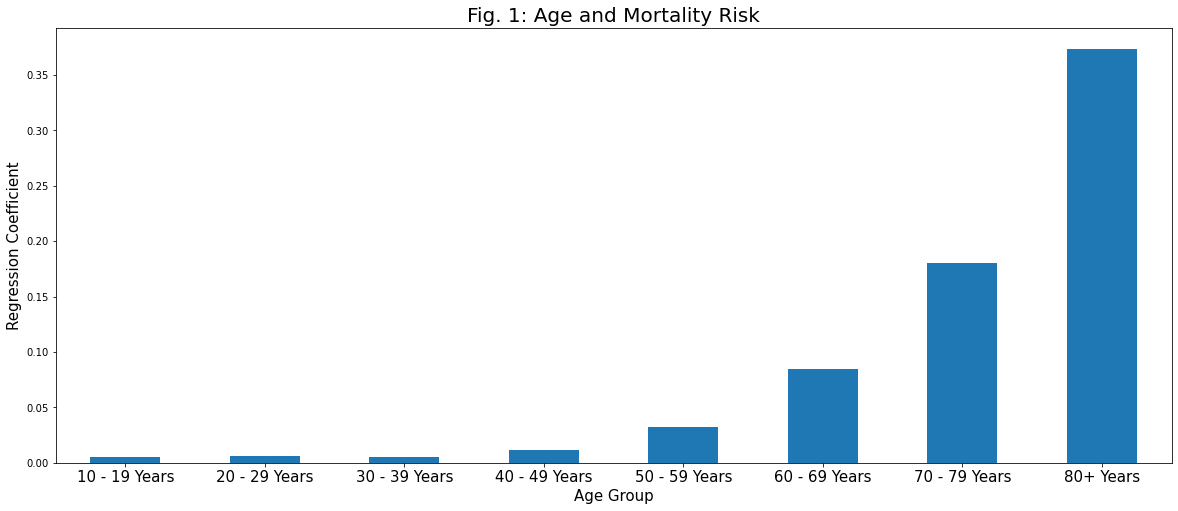

In [95]:
#Figure 1 calculation

plt.figure(figsize = (20,8))
plt.ylabel('Regression Coefficient', fontsize = 15)
plt.xlabel('Age Group', fontsize = 15)
res.params.loc['10 - 19 Years': '80+ Years'].plot(kind = 'bar')
plt.xticks(rotation = 0, fontsize= 15)
plt.title('Fig. 1: Age and Mortality Risk', fontsize = 20)
plt.savefig('Images/Regression/fig1_age.png', facecolor = 'white')
plt.show()


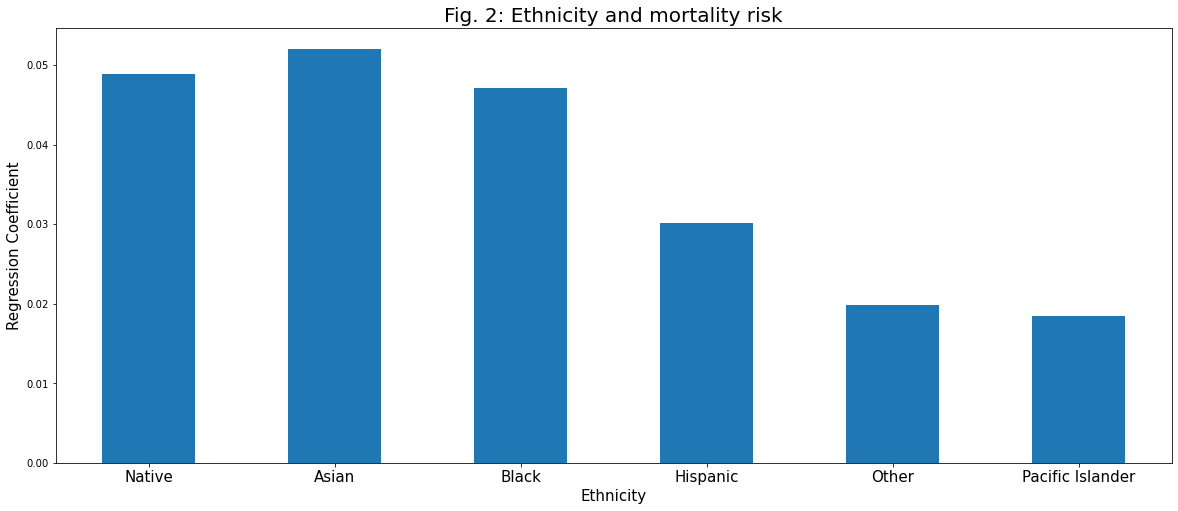

In [96]:
# Figure 2 calculations

plt.figure(figsize = (20,8))
plt.title('Fig. 2: Ethnicity and mortality risk', fontsize = 20)
plt.ylabel('Regression Coefficient', fontsize = 15)
plt.xlabel('Ethnicity', fontsize = 15)

res.params.loc['Native': 'Pacific Islander'].plot(kind = 'bar', )
plt.xticks(rotation = 0, fontsize= 15)
plt.savefig('Images/Regression/fig2_ethnicity.png', facecolor = 'white')
plt.show()

## Predicting Death
So we have demonstrated strong correlation, but what about predictive power? What do our predicted probabilities of death look like when compared with the actual results?

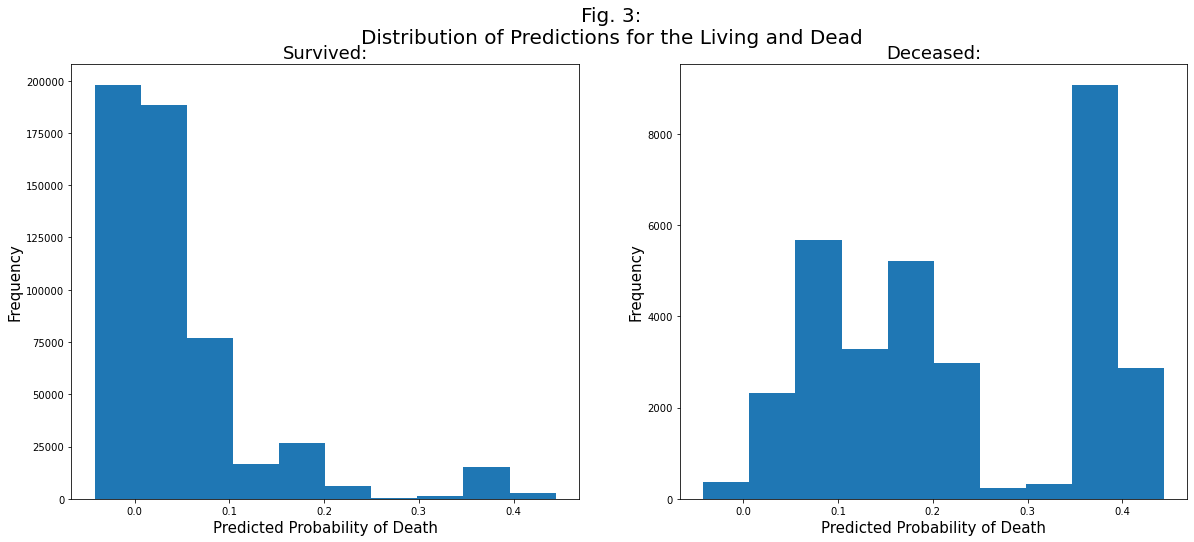

In [97]:
# Generate predictions
df['LPM Prediction'] = res.predict(x)

predictions = df[['LPM Prediction', 'death_yn']]

deaths = predictions[predictions['death_yn'] == True]
lives = predictions[predictions['death_yn'] == False]

fig, axs = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle('Fig. 3:\nDistribution of Predictions for the Living and Dead', fontsize= 20)
axs[0].hist(lives['LPM Prediction'])
axs[0].set_title('Survived:', fontsize = 18)
axs[0].set_xlabel('Predicted Probability of Death', fontsize = 15)
axs[0].set_ylabel('Frequency', fontsize = 15)

axs[1].hist(deaths['LPM Prediction'], bins = 10)
axs[1].set_title('Deceased:', fontsize = 18)
axs[1].set_xlabel('Predicted Probability of Death', fontsize= 15)
axs[1].set_ylabel('Frequency', fontsize = 15)

plt.savefig('Images/Regression/fig3_prediction_distribution.png', facecolor = 'white')
plt.show()

## Analyzing Results
It looks like there is a clear pattern between predicted probability of death and actual risk of death. However, the predictions are clearly skewed. The highest predicted probability of death was .46, meaning *no one* was deemed by the model to have a greater chance of dying than surviving. This is due to the fact that only around 6 percent of patients in this dataset ended up dying. 

Even when you look at the population which is most at risk (80+ year olds), 60% of them survived. So it stands to reason that the model would fail to give a patient a 50+% chance of death, when fewer than 50% of even the most vulnerable patients actually passed away.

In [98]:
# Compare summary statistics for living and dead
dead = pd.DataFrame(df[df['death_yn'] == 1]['LPM Prediction'].describe())
alive = pd.DataFrame(df[df['death_yn'] == 0]['LPM Prediction'].describe())

compare = pd.merge(dead, alive, left_index= True, right_index= True, suffixes = ['_dead', '_alive'])
compare.iloc[1:]

,LPM Prediction_dead,LPM Prediction_alive
mean,0.231278,0.046692
std,0.133940,0.086770
min,-0.042316,-0.042316
25%,0.103198,-0.006286
50%,0.199063,0.024437
75%,0.367384,0.067196
max,0.444473,0.444473


In [99]:
# Save dataframe for more in-depth regression 
df.to_csv('Data/regression_dataframe.csv', index= False)

# 3.1 Examining the Effects of Medical Conditions
The purpose of this section is to better understand the effect of pre-existing medical conditions on mortality risk from Covid-19. 

When I saw the relatively small coefficient for the medcond_yn variable in the original regression, I thought we probably needed to introduce some interaction variables into the model. In linear regression, an interaction variable allows for the effect of one variable (age, ethnicity) to depend on another variable (medcond_yn). In this case, it is reasonable to assume that the presence of a medical condition will present a different degree of risk for a 20 year-old, a 50-year old, and an 80 year-old.

We can simply multiply the values of our medcond_yn variable with our dummy classification variables for age and ethnicity. The resulting effect is two regression coefficients per age / ethnicity group. One for those with, and one for those without a pre-existing medical condition. For further reading, check out https://www.theanalysisfactor.com/interaction-dummy-variables-in-linear-regression/

In [100]:
df = pd.read_csv('Data/regression_dataframe.csv')
df.head()

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,...,70 - 79 Years,80+ Years,Asian,Black,Hispanic,Native,Other,Pacific Islander,White,LPM Prediction
0,2020/03/22,2020/03/22,2020/03/23,2020/03/22,Laboratory-confirmed case,0.0,0 - 9 Years,Hispanic,0.0,0.0,...,0,0,0,0,1,0,0,0,0,-0.012106
1,2020/03/22,2020/03/26,2020/03/23,2020/03/22,Laboratory-confirmed case,1.0,0 - 9 Years,White,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0.018699
2,2020/03/22,2020/03/22,2020/03/23,2020/03/22,Laboratory-confirmed case,1.0,0 - 9 Years,White,0.0,0.0,...,0,0,0,0,0,0,0,0,1,-0.017304
3,2020/03/23,2020/03/27,2020/03/24,2020/03/23,Laboratory-confirmed case,0.0,0 - 9 Years,Other,0.0,0.0,...,0,0,0,0,0,0,1,0,0,-0.022434
4,2020/03/21,2020/03/21,2020/03/24,2020/03/21,Laboratory-confirmed case,0.0,0 - 9 Years,White,0.0,0.0,...,0,0,0,0,0,0,0,0,1,-0.006314


,Deaths,Cases,Pct
Without,2084.0,258327,0.806729
With,30276.0,306797,9.868415


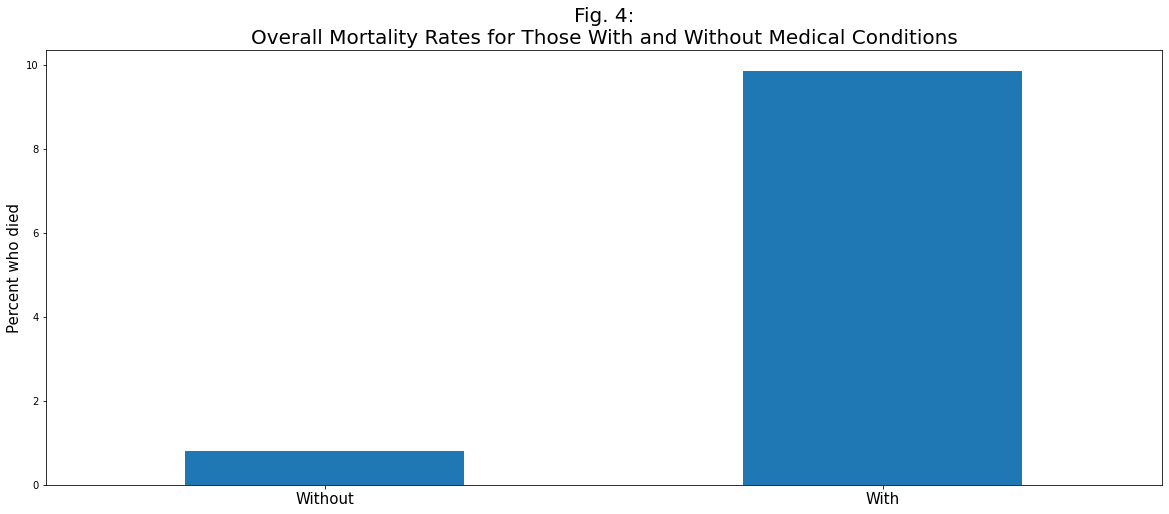

In [101]:
deaths = df.groupby('medcond_yn').sum()['death_yn']
counts = df.groupby('medcond_yn').count()['death_yn']
frame = pd.DataFrame({'Deaths': deaths, 'Cases': counts})
frame['Pct'] = 100 * (frame['Deaths'] / frame['Cases'])
frame.index =['Without', 'With']
frame['Pct'].plot(kind='bar', figsize=(20,8))
plt.ylabel('Percent who died', fontsize = 15)
plt.tick_params(labelrotation = 0)
plt.xticks( fontsize = 15)
plt.title('Fig. 4:\nOverall Mortality Rates for Those With and Without Medical Conditions', fontsize = 20)
plt.savefig('Images/Regression/fig4_medcond_distribution.png', facecolor = 'white')
frame

In [102]:
# Declare which columns will be interacted with
columns = ['20 - 29 Years', '30 - 39 Years',
       '40 - 49 Years', '50 - 59 Years', '60 - 69 Years', '70 - 79 Years',
       '80+ Years', 'Asian', 'Black', 'Hispanic', 'Native', 'Other',
       'Pacific Islander']

interactions = []
# Multiply each column with medcond_yn to create a new column
for col in columns:
    colName = col + '_interact'
    df[colName] = df[col] * df['medcond_yn']
    interactions.append(colName)
df[interactions].head()


,20 - 29 Years_interact,30 - 39 Years_interact,40 - 49 Years_interact,50 - 59 Years_interact,60 - 69 Years_interact,70 - 79 Years_interact,80+ Years_interact,Asian_interact,Black_interact,Hispanic_interact,Native_interact,Other_interact,Pacific Islander_interact
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
# Perform analysis
exog = ['sex'] + columns + interactions + ['medcond_yn']
x = df[exog]
x = sm.add_constant(x)

y = df['death_yn']

model = sm.OLS(y, x, hasconst = True)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               death_yn   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     4972.
Date:                Sat, 02 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:20:10   Log-Likelihood:                 85175.
No. Observations:              565124   AIC:                        -1.703e+05
Df Residuals:                  565095   BIC:                        -1.700e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.0127      0.001    -12.231      0.000      -0.015      -0.011
sex                           0.0244      0.001     43.912      0.000       0.023       0.026
20 - 29 Years                 0.0009      0.001      0.748      0.455      -0.002       0.003
30 - 39 Years                 0.0010      0.001      0.760      0.447      -0.002       0.004
40 - 49 Years                 0.0037      0.001      2.649      0.008       0.001       0.007
50 - 59 Years                 0.0084      0.001      5.587      0.000       0.005       0.011
60 - 69 Years                 0.0214      0.002     11.750      0.000       0.018       0.025
70 - 79 Years                 0.0607      0.003     23.290      0.000       0.056       0.066
80+ Years                     0.1900      0.004     52.506      0.000       0.183       0.197
Asian                         0.0052      0.002      2.240      0.025       0.001       0.010
Black                         0.0083      0.002      5.422      0.000       0.005       0.011
Hispanic                      0.0025      0.001      2.532      0.011       0.001       0.004
Native                        0.0120      0.008      1.417      0.157      -0.005       0.029
Other                         0.0016      0.002      0.710      0.478      -0.003       0.006
Pacific Islander              0.0137      0.006      2.267      0.023       0.002       0.026
20 - 29 Years_interact        0.0044      0.002      2.056      0.040       0.000       0.009
30 - 39 Years_interact        0.0105      0.002      4.832      0.000       0.006       0.015
40 - 49 Years_interact        0.0208      0.002      9.564      0.000       0.017       0.025
50 - 59 Years_interact        0.0483      0.002     22.134      0.000       0.044       0.053
60 - 69 Years_interact        0.1011      0.002     41.709      0.000       0.096       0.106
70 - 79 Years_interact        0.1642      0.003     52.688      0.000       0.158       0.170
80+ Years_interact            0.2298      0.004     56.832      0.000       0.222       0.238
Asian_interact                0.0923      0.003     27.167      0.000       0.086       0.099
Black_interact                0.0599      0.002     31.857      0.000       0.056       0.064
Hispanic_interact             0.0534      0.001     36.763      0.000       0.051       0.056
Native_interact               0.0589      0.010      5.741      0.000       0.039       0.079
Other_interact                0.0317      0.003      9.977      0.000       0.025       0.038
Pacific Islander_interact     0.0117      0.008      1.499      0.134      -0.004       0.027
medcond_yn                   -0.0247      0.002    -14.655      0.000      -0.028      -0.021
===========================================================================

# Interpretation
Woah! Big change in coefficients!

In the first regression, we estimated that being 80+ years old increased an individual's likelihood of death by around 40%. Now that we have distinguished between those with a medical condition and those without, that number has dropped to 20%. However, 80 year olds *with* a medical condition have an estimated mortality risk of *over* 40% (20.75 + 23.54). 

Where we before estimated that 60-69 year-old patients had an almost 10% increased risk of death, we now have them at just 2%! However, those with a medical condition have around a 14% (2.23 + 11.46) risk of dying!

The inclusion of this interaction variable has really enhanced the specificity of our results. Let's visualize each age group's mortality, ***taking pre-existing conditions into consideration*** 

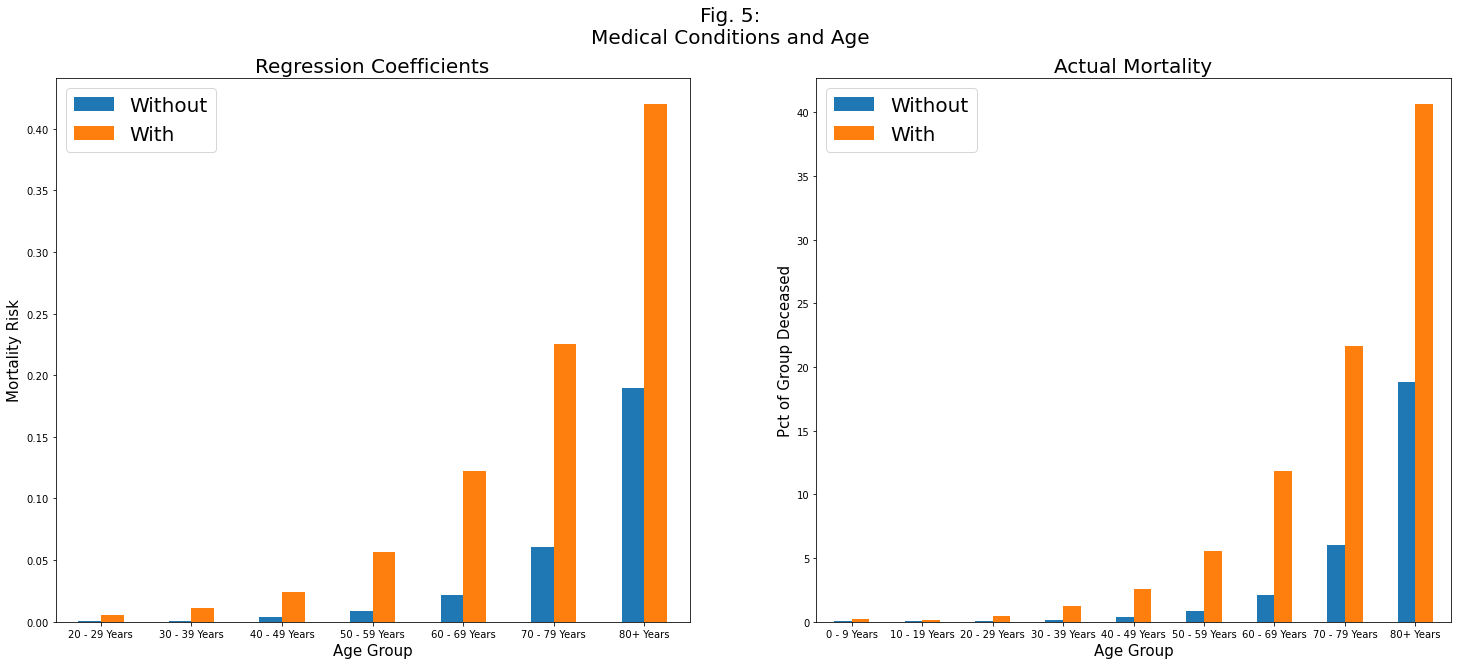

In [104]:
# Plot Setup:
fig, axs = plt.subplots(1, 2, figsize = (25,10))
fig.suptitle('Fig. 5:\nMedical Conditions and Age', fontsize = 20)

axs[0].set_ylabel('Mortality Risk', fontsize = 15)
axs[1].set_ylabel('Pct of Group Deceased', fontsize = 15)
axs[0].set_title('Regression Coefficients', fontsize = 20)
axs[1].set_title('Actual Mortality', fontsize = 20)


# Coefficients:
Without = res.params.loc['20 - 29 Years': '80+ Years']
With = res.params.loc['20 - 29 Years_interact':'80+ Years_interact']

coefficients = pd.DataFrame({'Without': Without.values, 'With': Without.values + With.values})
coefficients.set_index(Without.index, inplace = True)

coefficients.plot(kind='bar', ax = axs[0])
axs[0].tick_params(labelrotation = 0)
axs[0].set_xlabel('Age Group', fontsize = 15)
axs[0].legend(['Without', 'With'], fontsize = 20)
#Actual Values:
# Groupby age group and medical condition - compare share of death
sums = df.groupby(['age_group', 'medcond_yn']).sum()['death_yn']
counts = df.groupby(['age_group', 'medcond_yn']).count()['death_yn']
compare = pd.merge(sums, counts, left_index = True, right_index = True).rename(columns = {'death_yn_x': 'Total Deaths',
                                                                                         'death_yn_y': 'Total Cases'})
compare['Pct Dead'] = (compare['Total Deaths'] / compare['Total Cases']) * 100
compare = compare['Pct Dead'].unstack().rename(columns= {0: 'Without', 1: 'With'})

compare.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('Age Group', fontsize = 15)
axs[1].tick_params(labelrotation = 0)
axs[1].legend(['Without', 'With'], fontsize = 20)

plt.savefig('Images/Regression/fig5_age_and_medcond.png', facecolor = 'white')
plt.show()

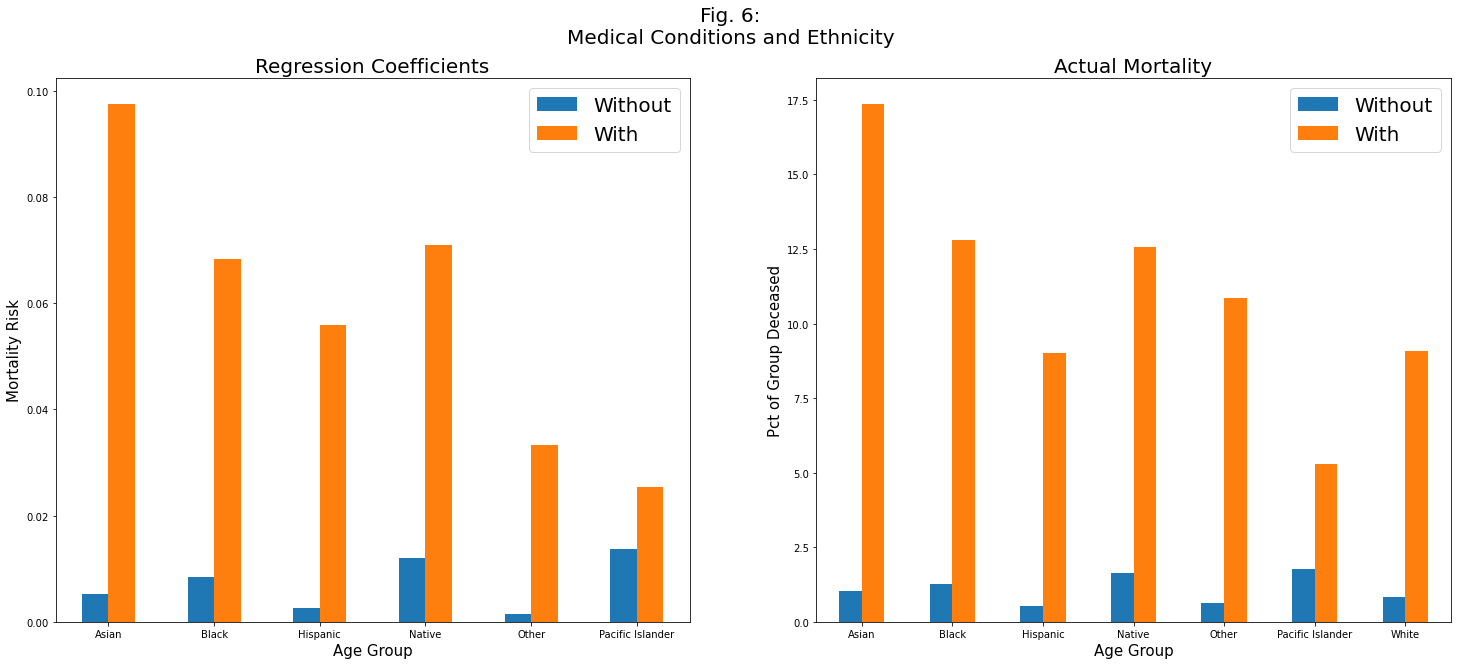

In [105]:
# Plot Setup:
fig, axs = plt.subplots(1, 2, figsize = (25,10))
fig.suptitle('Fig. 6:\nMedical Conditions and Ethnicity', fontsize = 20)

axs[0].set_ylabel('Mortality Risk', fontsize = 15)
axs[1].set_ylabel('Pct of Group Deceased', fontsize = 15)
axs[0].set_title('Regression Coefficients', fontsize = 20)
axs[1].set_title('Actual Mortality', fontsize = 20)


# Coefficients:
Without = res.params.loc['Asian': 'Pacific Islander']
With = res.params.loc['Asian_interact':'Pacific Islander_interact']

coefficients = pd.DataFrame({'Without': Without.values, 'With': Without.values + With.values})
coefficients.set_index(Without.index, inplace = True)

coefficients.plot(kind='bar', ax = axs[0])
axs[0].tick_params(labelrotation = 0)
axs[0].set_xlabel('Age Group', fontsize = 15)
axs[0].legend(['Without', 'With'], fontsize = 20)
#Actual Values:
# Groupby age group and medical condition - compare share of death
sums = df.groupby(['race_ethnicity_combined', 'medcond_yn']).sum()['death_yn']
counts = df.groupby(['race_ethnicity_combined', 'medcond_yn']).count()['death_yn']
compare = pd.merge(sums, counts, left_index = True, right_index = True).rename(columns = {'death_yn_x': 'Total Deaths',
                                                                                         'death_yn_y': 'Total Cases'})
compare['Pct Dead'] = (compare['Total Deaths'] / compare['Total Cases']) * 100
compare = compare['Pct Dead'].unstack().rename(columns= {0: 'Without', 1: 'With'})

compare.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('Age Group', fontsize = 15)
axs[1].tick_params(labelrotation = 0)
axs[1].legend(['Without', 'With'], fontsize = 20)

plt.savefig('Images/Regression/fig6_ethnicity_and_medcond.png', facecolor = 'white')
plt.show()

## Interpretation
So this graph tells  us two things:
1. Asian and Black people see the highest increased risk of mortality with the presence of pre-existing conditions
2. The presence of pre-existing medical conditions is a much higher risk factor than what the first model initally suggested 

## Why the big change?
Recall that in the first model, the presence of a medical condition was estimated to increase mortality risk by just 3 percent. When specifying by ethnicity and age, however, we see much larger coefficients for the presence of a medical condition. Before, we had not properly specified the model somehow. But how?

One possibility is that the majority of those with medical conditions are young, and they see very little increased risk. If the majority of patients in this dataset are young, then an unspecified regression analysis would see that the majority of those with medical conditions do **not** pass away.

Another possibility is that the majority of those with medical conditions are very *old*, and the regression has "confused" the effect of age with the effect of medical condition. If the majority of those with medical conditions are 80+ years old, and 80+ year-olds see the highest rate of mortality, then an unspecified regression analysis would see a much stronger correlation between *age* and mortality than between the presence of medical conditions and mortality.

Lets look at the distribution of medical conditions by age and see if either of these guesses are correct.

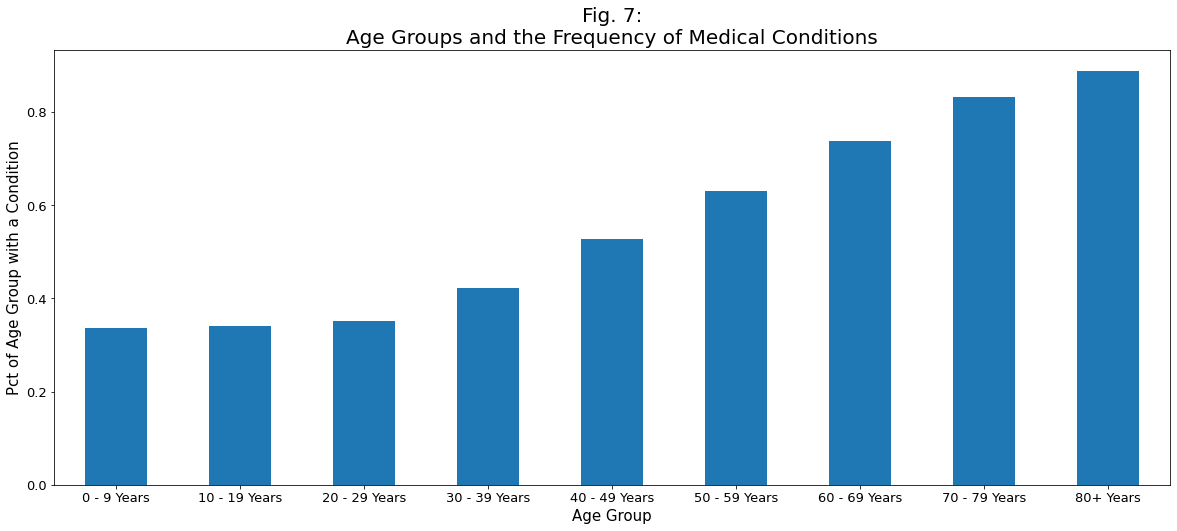

In [106]:
# Group by age group and show intra-group frequency of medical conditions
sums = df.groupby('age_group').sum()['medcond_yn']
counts = df.groupby('age_group').count()['medcond_yn']

totals = pd.DataFrame({'Total With Conditions': sums, 'Total': counts})
totals['Pct'] = totals['Total With Conditions'] / totals['Total']
totals['Pct'].plot(kind = 'bar', figsize = (20,8))
totals['Pct of Pop'] = totals['Total'] / df.shape[0]
plt.ylabel('Pct of Age Group with a Condition', fontsize = 15)
plt.xlabel('Age Group', fontsize = 15)
plt.xticks(rotation = 0, fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('Fig. 7:\nAge Groups and the Frequency of Medical Conditions', fontsize = 20)
plt.savefig('Images/Regression/fig7_age_medcond_distribution.png', facecolor = 'white')
plt.show()

## Age Bias
It does, in fact, look like the presence of medical conditions is heavily skewed with age. Not only that, but the majority of observations in this dataset are of individuals younger than 60 years old. In other words, most observations are of people for whom the presence of a medical condition increases mortality risk by less than 10%

This explains why we see such a huge disparity in the medcond_yn coefficients before and after including the interaction variables.

By specifying the intra-group presence of medical conditions, we have painted a much clearer picture of the causes of mortality 

## Predictive Power
Now that we have re-specified our model, we can check its predictive power again.

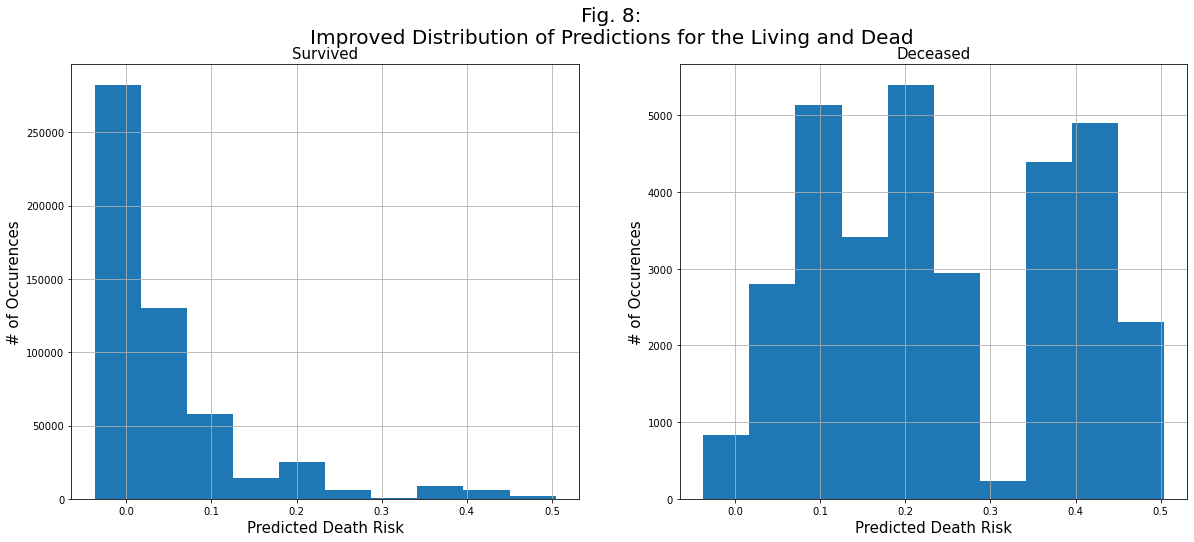

In [107]:
# Replace current prediction estimates (from the last regression)
df['LPM Prediction'] = res.predict(x)
deaths = df[df['death_yn'] == 1]
lives = df[df['death_yn'] == 0]

fig, axs = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle('Fig. 8:\nImproved Distribution of Predictions for the Living and Dead', fontsize = 20)
lives['LPM Prediction'].hist(ax = axs[0])
deaths['LPM Prediction'].hist(ax = axs[1])
for ax in axs:
    ax.set_xlabel('Predicted Death Risk', fontsize = 15)
    ax.set_ylabel('# of Occurences', fontsize = 15)

axs[0].set_title('Survived', fontsize = 15)
axs[1].set_title('Deceased', fontsize = 15)

plt.savefig('Images/Regression/fig8_improved_prediction_distribution.png')
plt.show()

## Better fit
Our prediction distribution looks **very** similar to the one from the first regression (Fig. 3) However, it is more skewed in the correct directions (left for the survived, right for the deceased). We have improved our model!
# 3.2 Changes over time
Thus far, we have not taken into account that the treatment options for Covid-19 have greatly improved over time. If we isolate the effect of time's passing, it will better enable us to identify the causal factors behind mortality risk.

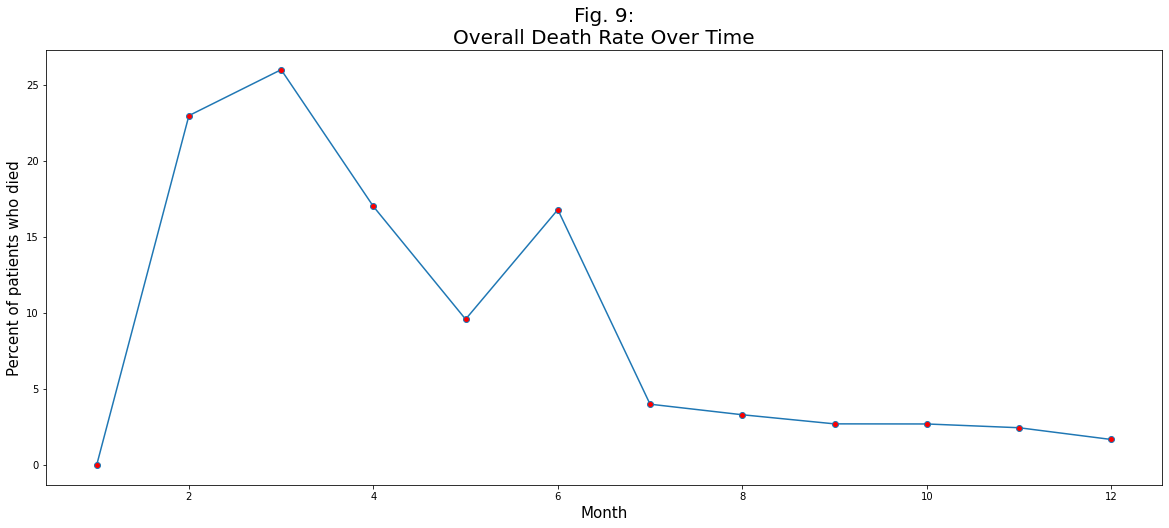

In [108]:
# First, let's visualize it
dead = df.groupby('month').sum()['death_yn']
counts = df.groupby('month').count()['death_yn']
deaths_by_month = pd.DataFrame({'Deaths': dead, 'Cases': counts})
deaths_by_month['Pct'] = (deaths_by_month['Deaths'] / deaths_by_month['Cases']) * 100
deaths_by_month['Pct'].plot(figsize = (20,8), marker = 'o', markerfacecolor = 'r')
plt.xlabel('Month', fontsize = 15)
plt.ylabel('Percent of patients who died', fontsize = 15)
plt.title('Fig. 9:\nOverall Death Rate Over Time', fontsize = 20)
plt.savefig('Images/Regression/fig9_death_over_time.png')

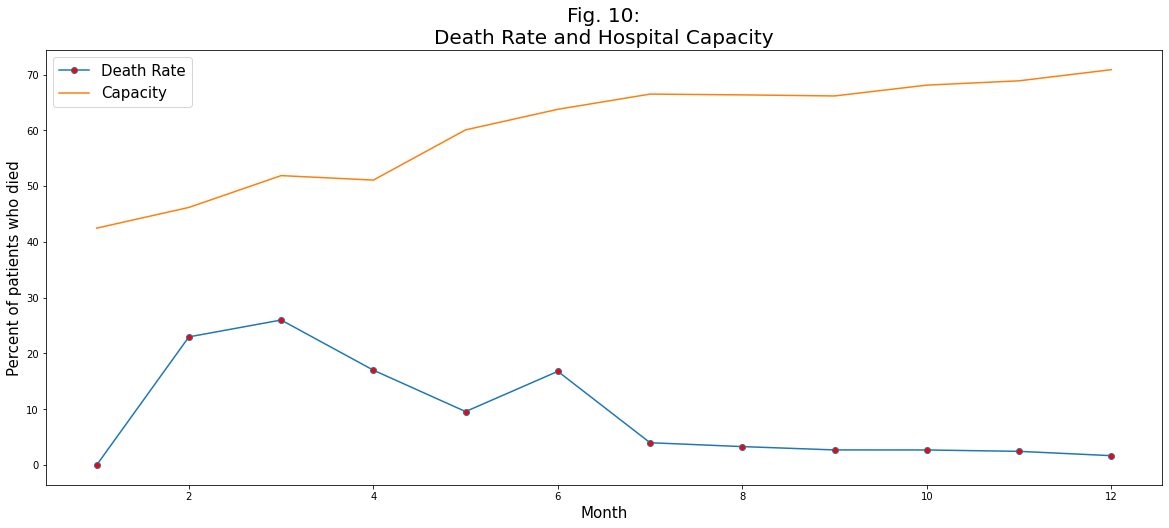

In [109]:
# Grab the occupancy column from the main dataframe
cap = pd.read_csv('Data/clean_data.csv')['inpatient__occupancy']
df['Hospital Capacity'] = cap
cap_by_month = df.groupby('month').mean()['Hospital Capacity'] * 100

# We got the column. Now let's plot it
deaths_by_month['Pct'].plot(figsize = (20,8), marker = 'o', markerfacecolor = 'r')
cap_by_month.plot()
plt.xlabel('Month', fontsize = 15)
plt.ylabel('Percent of patients who died', fontsize = 15)
plt.title('Fig. 10:\nDeath Rate and Hospital Capacity', fontsize = 20)
plt.legend(['Death Rate', 'Capacity'], fontsize = 15)
plt.savefig('Images/Regression/fig10_death_and_capacity.png')

It seems that over time, hospital occupancy has gone up, and the death rate has gone down in spite of this fact. Now, let's quantify the time effect by introducing some time-fixed-effects into our model. Not only will this reflect the trend seen above in Fig. 10, but it will allow the regression software to specify its other coefficients even more accurately due to the mitigation of ommitted variable bias.

In [110]:
months = pd.get_dummies(df['month'])
months

# This for loop is the same as a merge. 
for i in range(2, 12):
    x['month ' + str(i)] = months[i]

x.head()

,const,sex,20 - 29 Years,30 - 39 Years,40 - 49 Years,50 - 59 Years,60 - 69 Years,70 - 79 Years,80+ Years,Asian,...,month 2,month 3,month 4,month 5,month 6,month 7,month 8,month 9,month 10,month 11
0,1.0,0.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1.0,1.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1.0,1.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1.0,0.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,1.0,0.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [111]:
model = sm.OLS(y, x, hasconst = True)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               death_yn   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     4454.
Date:                Sat, 02 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:20:18   Log-Likelihood:                 96983.
No. Observations:              565124   AIC:                        -1.939e+05
Df Residuals:                  565085   BIC:                        -1.934e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.0246      0.001    -19.790      0.000      -0.027      -0.022
sex                           0.0218      0.001     40.065      0.000       0.021       0.023
20 - 29 Years                -0.0063      0.001     -5.089      0.000      -0.009      -0.004
30 - 39 Years                -0.0081      0.001     -6.143      0.000      -0.011      -0.005
40 - 49 Years                -0.0059      0.001     -4.267      0.000      -0.009      -0.003
50 - 59 Years                -0.0021      0.001     -1.401      0.161      -0.005       0.001
60 - 69 Years                 0.0119      0.002      6.668      0.000       0.008       0.015
70 - 79 Years                 0.0538      0.003     21.074      0.000       0.049       0.059
80+ Years                     0.1795      0.004     50.638      0.000       0.173       0.186
Asian                        -0.0100      0.002     -4.418      0.000      -0.014      -0.006
Black                        -0.0031      0.002     -2.077      0.038      -0.006      -0.000
Hispanic                     -0.0157      0.001    -15.842      0.000      -0.018      -0.014
Native                       -0.0029      0.008     -0.348      0.728      -0.019       0.013
Other                        -0.0025      0.002     -1.144      0.253      -0.007       0.002
Pacific Islander             -0.0077      0.006     -1.301      0.193      -0.019       0.004
20 - 29 Years_interact        0.0014      0.002      0.671      0.502      -0.003       0.006
30 - 39 Years_interact        0.0069      0.002      3.210      0.001       0.003       0.011
40 - 49 Years_interact        0.0170      0.002      8.010      0.000       0.013       0.021
50 - 59 Years_interact        0.0413      0.002     19.309      0.000       0.037       0.045
60 - 69 Years_interact        0.0899      0.002     37.851      0.000       0.085       0.095
70 - 79 Years_interact        0.1476      0.003     48.333      0.000       0.142       0.154
80+ Years_interact            0.2064      0.004     52.062      0.000       0.199       0.214
Asian_interact                0.0831      0.003     24.956      0.000       0.077       0.090
Black_interact                0.0538      0.002     29.177      0.000       0.050       0.057
Hispanic_interact             0.0482      0.001     33.899      0.000       0.045       0.051
Native_interact               0.0682      0.010      6.786      0.000       0.048       0.088
Other_interact                0.0248      0.003      7.973      0.000       0.019       0.031
Pacific Islander_interact     0.0202      0.008      2.641      0.008       0.005       0.035
medcond_yn                   -0.0247      0.002    -14.961      0.000      -0.028      -0.021
month 2                       0.1522      0.024      6.418      0.000      

At first glance, it looks like the size of most of our coefficients have remained the same

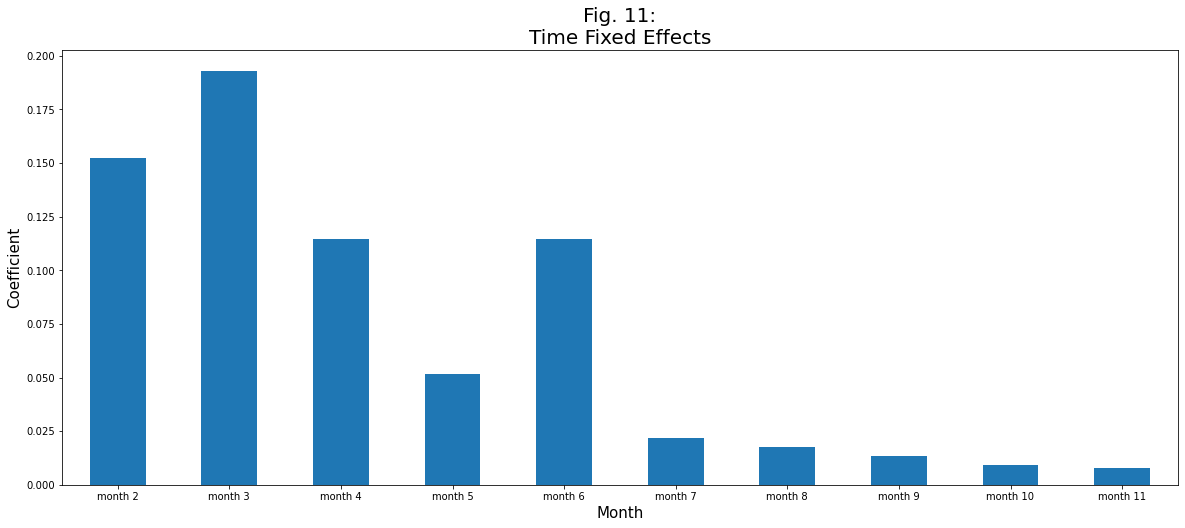

In [112]:
res.params.loc['month 2': 'month 11'].plot(kind = 'bar', figsize = (20,8))
plt.tick_params(labelrotation = 0)
plt.xlabel('Month', fontsize = 15)
plt.ylabel('Coefficient', fontsize = 15)
plt.title('Fig. 11:\nTime Fixed Effects', fontsize = 20)
plt.savefig('Images/Regression/fig11_time_fixed_effects')

## Model Respecification
By introducing these time-fixed-effects, we have certainly changed the regression coefficients. Let's see if our above observations continue to hold water after re-specifying the model 

***Note***: *The below code is a copy-paste from the code that generated figures 5 and 6*

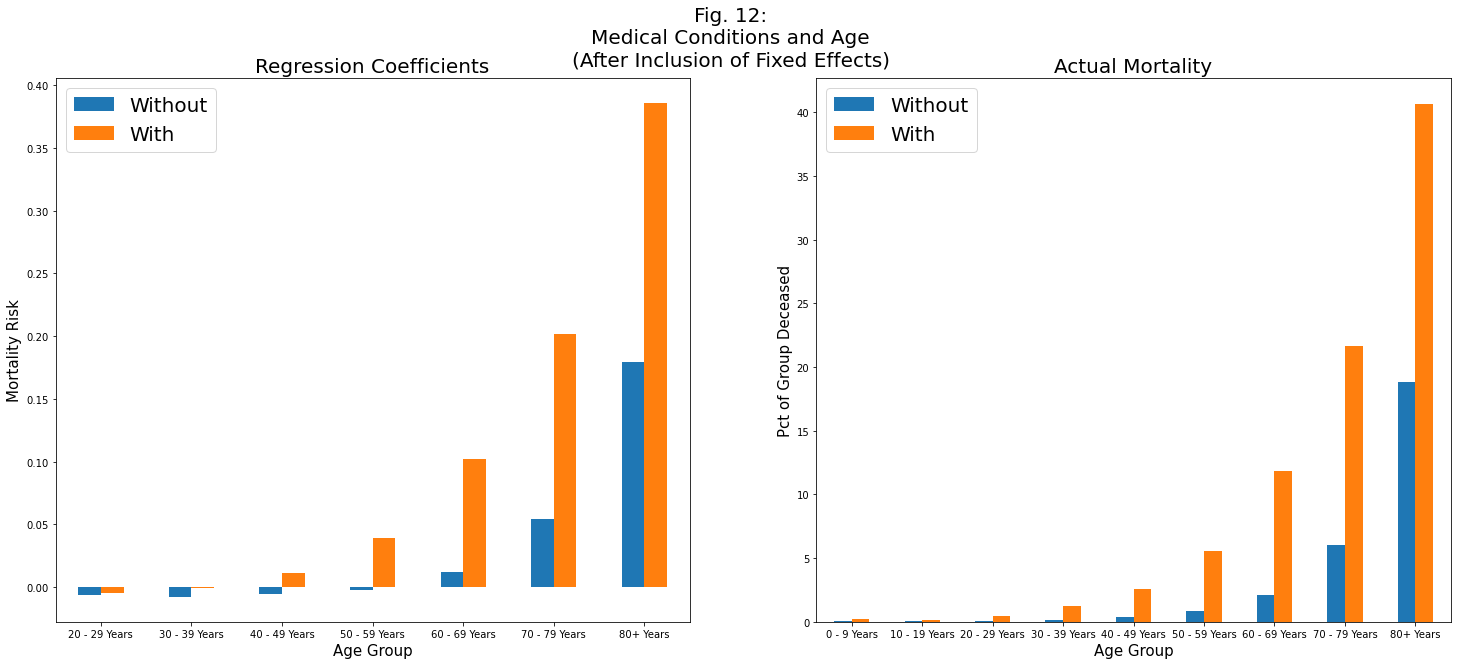

In [113]:
# Plot Setup:
fig, axs = plt.subplots(1, 2, figsize = (25,10))
fig.suptitle('Fig. 12:\nMedical Conditions and Age\n(After Inclusion of Fixed Effects)', fontsize = 20)

axs[0].set_ylabel('Mortality Risk', fontsize = 15)
axs[1].set_ylabel('Pct of Group Deceased', fontsize = 15)
axs[0].set_title('Regression Coefficients', fontsize = 20)
axs[1].set_title('Actual Mortality', fontsize = 20)


# Coefficients:
Without = res.params.loc['20 - 29 Years': '80+ Years']
With = res.params.loc['20 - 29 Years_interact':'80+ Years_interact']

coefficients = pd.DataFrame({'Without': Without.values, 'With': Without.values + With.values})
coefficients.set_index(Without.index, inplace = True)

coefficients.plot(kind='bar', ax = axs[0])
axs[0].tick_params(labelrotation = 0)
axs[0].set_xlabel('Age Group', fontsize = 15)
axs[0].legend(['Without', 'With'], fontsize = 20)
#Actual Values:
# Groupby age group and medical condition - compare share of death
sums = df.groupby(['age_group', 'medcond_yn']).sum()['death_yn']
counts = df.groupby(['age_group', 'medcond_yn']).count()['death_yn']
compare = pd.merge(sums, counts, left_index = True, right_index = True).rename(columns = {'death_yn_x': 'Total Deaths',
                                                                                         'death_yn_y': 'Total Cases'})
compare['Pct Dead'] = (compare['Total Deaths'] / compare['Total Cases']) * 100
compare = compare['Pct Dead'].unstack().rename(columns= {0: 'Without', 1: 'With'})

compare.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('Age Group', fontsize = 15)
axs[1].tick_params(labelrotation = 0)
axs[1].legend(['Without', 'With'], fontsize = 20)

plt.savefig('Images/Regression/fig12_age_and_medcond_post_FE.png', facecolor = 'white')
plt.show()

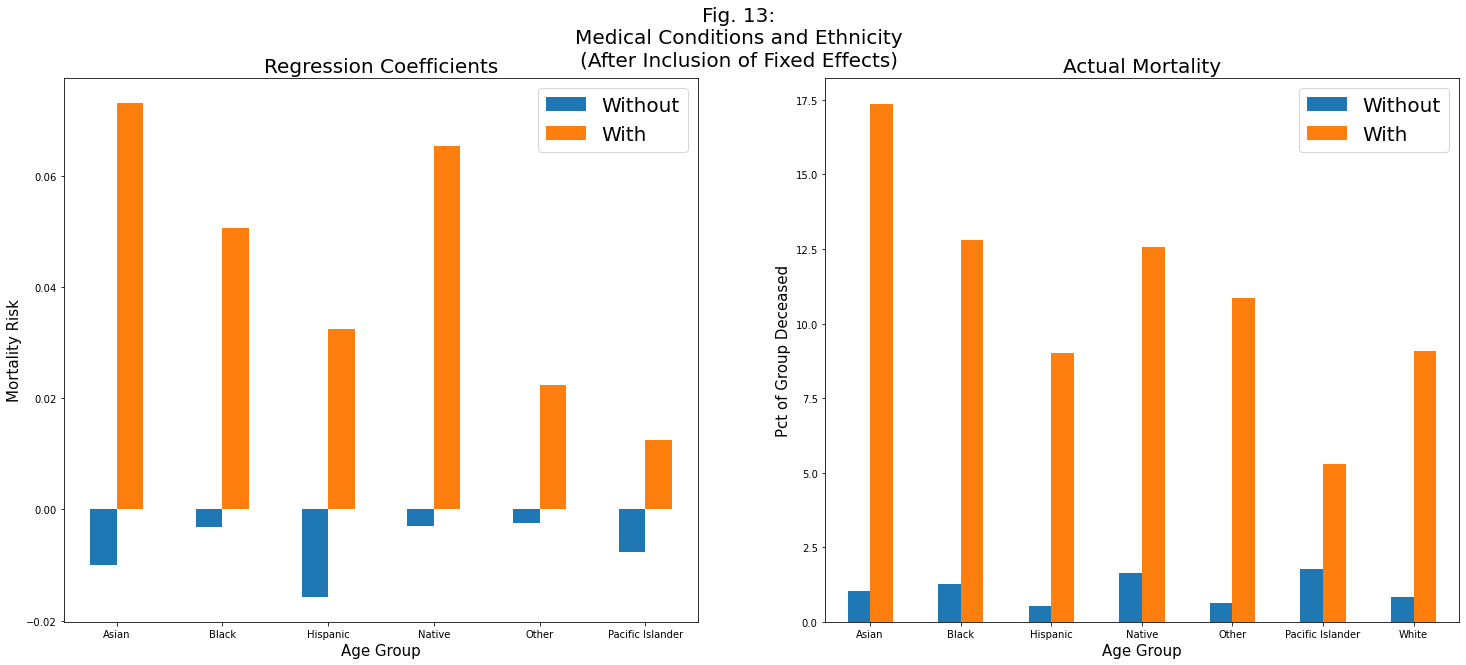

In [114]:
# Plot Setup:
fig, axs = plt.subplots(1, 2, figsize = (25,10))
fig.suptitle('Fig. 13:\nMedical Conditions and Ethnicity\n(After Inclusion of Fixed Effects)', fontsize = 20)

axs[0].set_ylabel('Mortality Risk', fontsize = 15)
axs[1].set_ylabel('Pct of Group Deceased', fontsize = 15)
axs[0].set_title('Regression Coefficients', fontsize = 20)
axs[1].set_title('Actual Mortality', fontsize = 20)


# Coefficients:
Without = res.params.loc['Asian': 'Pacific Islander']
With = res.params.loc['Asian_interact':'Pacific Islander_interact']

coefficients = pd.DataFrame({'Without': Without.values, 'With': Without.values + With.values})
coefficients.set_index(Without.index, inplace = True)

coefficients.plot(kind='bar', ax = axs[0])
axs[0].tick_params(labelrotation = 0)
axs[0].set_xlabel('Age Group', fontsize = 15)
axs[0].legend(['Without', 'With'], fontsize = 20)
#Actual Values:
# Groupby age group and medical condition - compare share of death
sums = df.groupby(['race_ethnicity_combined', 'medcond_yn']).sum()['death_yn']
counts = df.groupby(['race_ethnicity_combined', 'medcond_yn']).count()['death_yn']
compare = pd.merge(sums, counts, left_index = True, right_index = True).rename(columns = {'death_yn_x': 'Total Deaths',
                                                                                         'death_yn_y': 'Total Cases'})
compare['Pct Dead'] = (compare['Total Deaths'] / compare['Total Cases']) * 100
compare = compare['Pct Dead'].unstack().rename(columns= {0: 'Without', 1: 'With'})

compare.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('Age Group', fontsize = 15)
axs[1].tick_params(labelrotation = 0)
axs[1].legend(['Without', 'With'], fontsize = 20)

plt.savefig('Images/Regression/fig13_ethnicity_and_medcond_post_FE.png', facecolor = 'white')
plt.show()

One noticeable change: There are now quite a few negative coefficients. If you look close, the pattern is the same as before. 

In other words, ***Relative to each other***, all of our coefficients have maintained the same values. We have simply given more accuracy to the model **overall** by introducing these time-fixed-effects. Our R-squared value rose by 15 percent (0.212 --> 0.244), so that is a good sign. An even better picture would be to repeat the excercise where we show the distribution of predicted probabilities.

*Note: R-squared went up, and that is a positive sign, but for Linear Probability Models, R-squared is a very poor measure of quality. It cannot be interpreted intuitively. That it rose is a good sign, but its value should always be taken with a grain of salt, especially in the case of a Linear Probability Model*

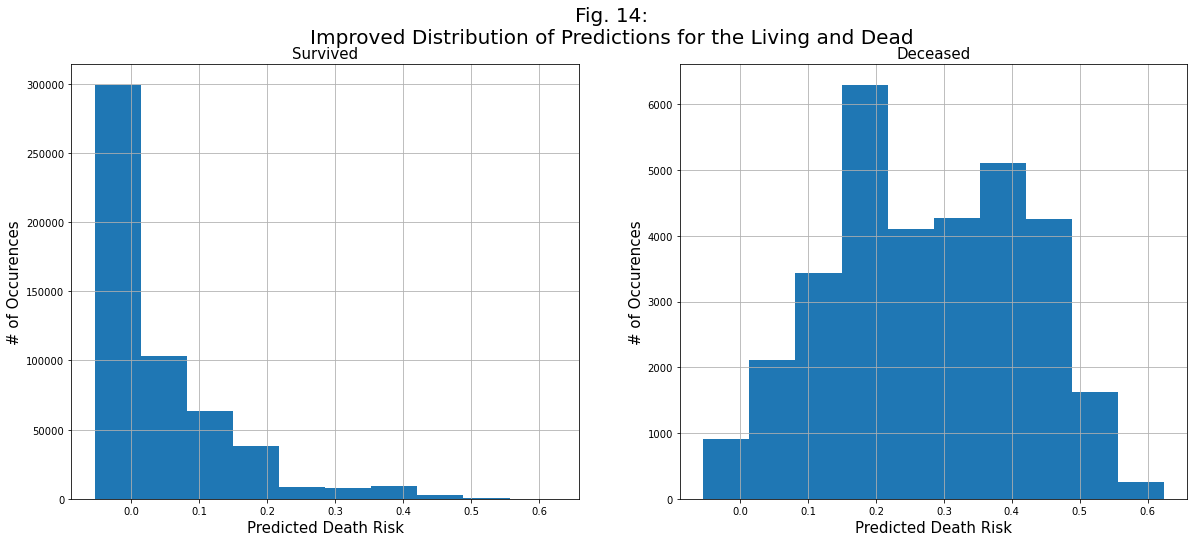

In [115]:
# Replace current prediction estimates (from the last regression)
df['LPM Prediction'] = res.predict(x)
deaths = df[df['death_yn'] == 1]
lives = df[df['death_yn'] == 0]

fig, axs = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle('Fig. 14:\nImproved Distribution of Predictions for the Living and Dead', fontsize = 20)
lives['LPM Prediction'].hist(ax = axs[0])
deaths['LPM Prediction'].hist(ax = axs[1])
for ax in axs:
    ax.set_xlabel('Predicted Death Risk', fontsize = 15)
    ax.set_ylabel('# of Occurences', fontsize = 15)

axs[0].set_title('Survived', fontsize = 15)
axs[1].set_title('Deceased', fontsize = 15)

plt.savefig('Images/Regression/fig14_improved_prediction_distribution_post_FE.png')
plt.show()

The distributions have moved *even further* in the correct directions.